In [1]:
import numpy as np
import scipy as scipy
import sys
import copy
import myfun as mf
import pickle as pkl

import matplotlib
from matplotlib import gridspec, rc
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

rc('text',usetex=True)

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata


# Needs: 
# pseudotime trajectory
# eigenvalues as function of time
# gexp for neutrophil genes
# gexp for myelocite genes

In [2]:
headdir    = '/Users/simonfreedman/cqub/bifurc/paper_figs/' #'.' #'/Users/simonfreedman/cqub/bifurc/weinreb_2020/'
figdir     = '{0}/figs'.format(headdir)
datdir     = '{0}/neutrophil_data'.format(headdir)
eigdir     = '{0}/eig'.format(datdir)

#gexp_fname = '{0}/gene_expr.npz'.format(datdir)
pst_fname  = '{0}/pseudotime.txt'.format(datdir)
gnm_fname  = '{0}/gene_names.txt'.format(datdir)
meta_fname = '{0}/metadata.txt'.format(datdir)

# In[6]:

# print('loading gene expression matrix')
# gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
# gexp_lil   = gexp_sp.tolil() # WT: 3 min 55 seconds


# In[8]:

print('loading cluster labels and SPRING positions')
dtp      = np.dtype([('Library Cell', np.unicode_, 16),('barcode', np.unicode_, 20),
              ('Time point', int),('Starting population', np.unicode_, 20),
               ('Cell type annotation', np.unicode_, 60),
               ('Well', int), ('SPRING-x', np.float64), ('SPRING-y', np.float64)])

metadata = np.genfromtxt(meta_fname, delimiter='\t',skip_header=1, dtype=dtp)

nms      = dtp.names
gnms     = np.genfromtxt(gnm_fname,dtype='str')


# In[9]:


keys           = metadata['Cell_type_annotation']
ctypes         = np.unique(keys)
ctype_idx_dict = dict(zip(ctypes,range(ctypes.shape[0])))
ctype_idxs     = np.array([ctype_idx_dict[k] for k in keys])
ctype_grps     = [np.where(ctype_idxs==i)[0] for i in range(len(ctypes))]
ctype_mean_pos = np.array([[np.mean(metadata['SPRINGx'][grp]),np.mean(metadata['SPRINGy'][grp])] 
                           for grp in ctype_grps])


# In[11]:

print('loading neutrophil pseudotime ranking')
neut_psts = np.genfromtxt(pst_fname, skip_header=True, dtype='int')


# In[12]:

print('binning gene expression')
bin_sz            = 1000
overlap           = int(bin_sz/2)

srt               = np.argsort(neut_psts[:,1])
last_full_bin     = int(np.floor(srt.shape[0]/overlap)*overlap) - bin_sz + overlap
neut_pst_grps     = [srt[i:(i+bin_sz)] for i in range(0,last_full_bin,overlap)]
neut_pst_grps[-1] = np.union1d(neut_pst_grps[-1], srt[last_full_bin:])
neut_pst_cidxs    = [np.array(neut_psts[grp,0], dtype = 'int') for grp in neut_pst_grps]
npsts             = len(neut_pst_cidxs)

# In[15]:


print('eigen-decomposition')

pst_eig1     = np.load('{0}/dat_eval.npy'.format(eigdir))[:,0]
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]

# In[16]:

# this takes a while, so run with script: pca_gene_resample.py -- see README.md for details

#pst_grp_null_eval     = np.load('{0}/w1_gene_resample_bsz{1}_ns{2}.npy'.format(datdir, bin_sz, nsamp))
pst_grp_null_eval     = np.array([np.load('{0}/shuf_eval_t{1}.npy'.format(eigdir,i))[:,0] for i in range(npsts)])
pst_grp_null_eval_mu  = np.mean(pst_grp_null_eval,axis=1)
pst_grp_null_eval_err = np.std(pst_grp_null_eval,axis=1)

# In[17]:


pst_eig1_n              = pst_eig1 - np.amin(pst_eig1)
pst_grp_null_eval_n     = pst_grp_null_eval-np.amin(pst_grp_null_eval)
pst_grp_null_eval_mu_n  = np.mean(pst_grp_null_eval_n,axis=1)
pst_grp_null_eval_err_n = np.std(pst_grp_null_eval_n,axis=1)

loading cluster labels and SPRING positions
loading neutrophil pseudotime ranking
binning gene expression
eigen-decomposition


In [3]:
# In[18]:

###############################################################
# gene expression of highly varying, highly expressed genes...#
###############################################################
print('matrix of gene expression for highly expressed / varying genes')

nnz_thresh  = 0
cv_thresh   = 0.5
gexp_thresh = 1

#mu_gexp = np.array([np.mean(gexp_lil[cidxs].toarray(),axis=0) for cidxs in neut_pst_cidxs]) # takes like a minute
mu_gexp = np.load('{0}/high_var_gexp_trajs.npy'.format(datdir))
# save mu_gexp!

# In[19]:

nnzs         = np.sum(mu_gexp>0,axis=0)
mu_mu_gexp   = np.mean(mu_gexp,axis=0)
max_mu_gexp  = np.max(mu_gexp,axis=0)

std_mu_gexp = np.std(mu_gexp,axis=0)
cvs         = np.divide(std_mu_gexp, mu_mu_gexp, out = np.zeros(mu_gexp.shape[1]), where=mu_mu_gexp>0)

gidxs       = np.where((nnzs > nnz_thresh) & (cvs>cv_thresh) & (max_mu_gexp>gexp_thresh))[0]
am_sort     = mf.argmaxsort(mu_gexp[:,gidxs])
gexp_arr    = mu_gexp[:,gidxs[am_sort[0]]].T

matrix of gene expression for highly expressed / varying genes


In [4]:
gexp_norm = np.linalg.norm(mu_gexp,axis=1)

In [5]:
gexp_norm_outer = np.outer(gexp_norm, gexp_norm)

In [6]:
mu_gexp_cc = mu_gexp.dot(mu_gexp.T)/gexp_norm_outer

In [7]:
# In[31]: null difference + tau_d
null_diff   = pst_eig1_n - pst_grp_null_eval_mu
t_bifurc    = np.argmax(null_diff)
t_bifurc_pf = np.where(null_diff>0)[0][0]
t_bifurc_pf = np.where(np.diff(pst_eig1_n)>125)[0][0]


In [8]:
# dnb calculation
dnb_biom = np.load('{0}/pst_dnb_nnz_0_cv0-5_gexp1.npy'.format(datdir))
dnb_biom = np.load('{0}/pst_dnb_markers.npy'.format(datdir))

In [28]:
dnb_biom_rand = np.load('{0}/pst_dnb_random.npy'.format(datdir))

In [15]:
ctypes_fix = [x.replace('_','\_') for x in ctypes]
ctypes_fix

['Baso',
 'Ccr7\\_DC',
 'Eos',
 'Erythroid',
 'Lymphoid',
 'Mast',
 'Meg',
 'Monocyte',
 'Neutrophil',
 'Undifferentiated',
 'pDC']

making figure 4


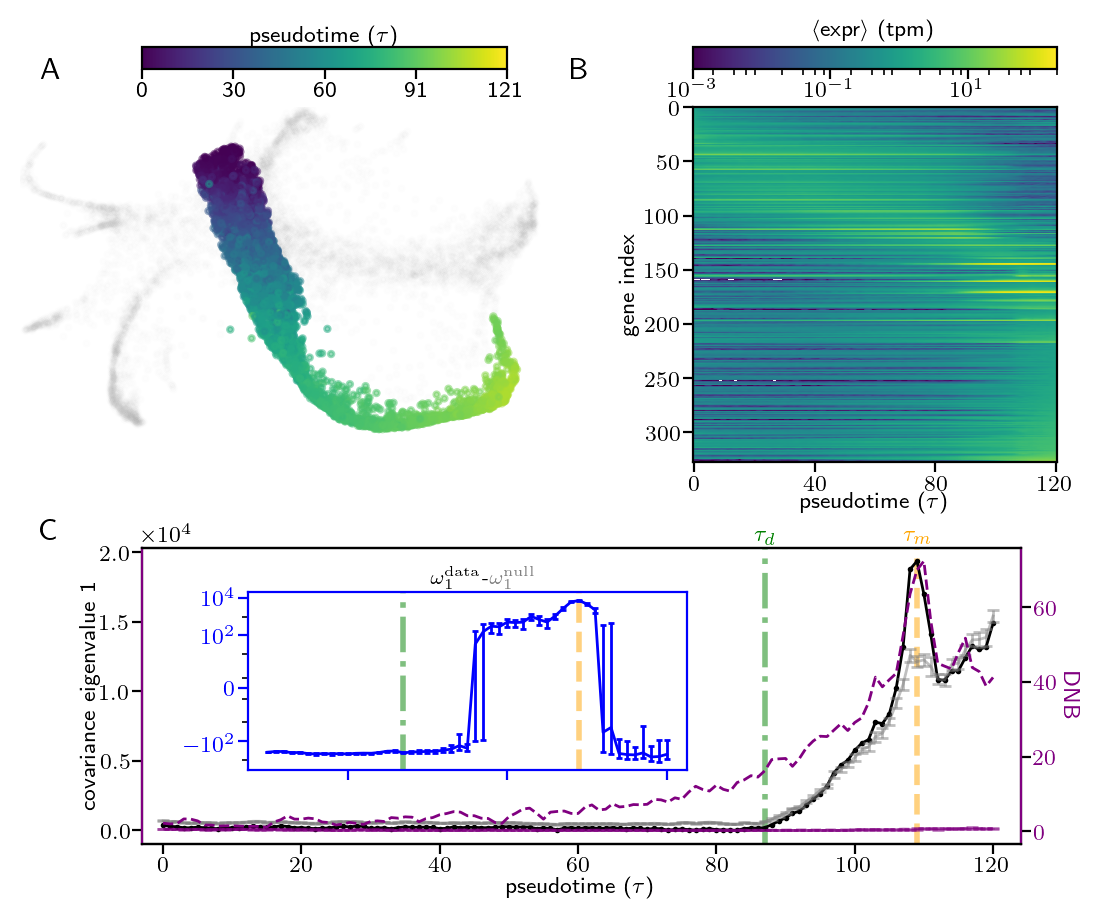

In [89]:
############################
#### fig 4 #################
############################
print('making figure 4')

plt.style.reload_library()
plt.style.use('one_col_fig')
# matplotlib.rcParams.update({'font.size': 7,
#                             'axes.titlesize':7, 
#                             'axes.labelsize':7,
#                             'xtick.labelsize':7,
#                            'ytick.labelsize':7,
#                            'legend.fontsize':7})
taulims = np.array([-3,124])
pst_label = r'pseudotime ($\tau$)'
leg_ht  = 2
leg_spc = 3
spc1_ht  = 7
spc2_ht = 0
spc1 = 1
schem1_ht   = 30
tseries_ht = 50
tau_series_ht = 25

col1_wd = 30
col2_wd = 30
spc_wd = 15
spc2_wd=1
spc3_wd=10

wds = np.array([
    spc3_wd,
    col1_wd,
    spc_wd,
    col2_wd-spc2_wd-leg_ht,
    spc2_wd,
    leg_ht
])

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

# row heights
hts = np.array([
    
    leg_ht,
    leg_spc,
    
    schem1_ht,   
    spc1_ht,
    spc2_ht,
    
    tau_series_ht,
])

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 17/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axAL = plt.subplot( gs[0    :rs[0],cs[0]:cs[1]]) # SPRING heat map legend
axA  = plt.subplot( gs[rs[1]:rs[3],0:cs[2]]) # SPRING heat map

axBL = plt.subplot( gs[0    :rs[0], cs[2]:]) # gene expression heat map legend
axB  = plt.subplot( gs[rs[1]:rs[2], cs[2]:]) # gene expression heat map

axC  = plt.subplot( gs[rs[4]:rs[5], cs[0]:cs[3]]) # covariance eigenvalue

caps = ['A','B','C']
ri   = [0,   0, rs[4]]
ci   = [0,cs[1],0]
ys   = [0,0,4]
xs   = [2,6,2]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], 
                x=xs[i],
                y=ys[i],fontsize=11,verticalalignment='top',horizontalalignment='left')
    cap_ax.axis('off')
    
#####################################
## A: SPRING plot                ####
#####################################
ab_cap_fs = 8
skip=10

# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.01)

axA.set_xlim(springXlims[0],springXlims[1]+1500)
axA.set_ylim(springYlims[0]-1500,springYlims[1])

# annotate cell types
ctype_offset = {'Monocyte':np.array([-500,200]),
               'Undifferentiated':np.array([-700,350]),
               'Lymphoid':np.array([-1300,100]),
                'pDC':np.array([-50,150]),
                'Erythroid':np.array([-400,0]),
               'Baso':np.array([-200,-400]),
               'Meg':np.array([-150,100])}

for i in range(len(ctypes)):
    axA.annotate(xy=ctype_mean_pos[i]+ctype_offset.get(ctypes[i],np.array([0,0])),
                 text=ctypes_fix[i],alpha=0.8,
                 fontsize=8 if ctypes[i] in ['Undifferentiated', 'Neutrophil'] else 7, 
                 color='red' if ctypes[i]=='Undifferentiated' else 'black')
    
# plot points in neutrophil trajectory
skip = 10
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
        c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)

axA.set_xticks([])
axA.set_yticks([])

#frameless
axA.axis('off')

#colorbar
cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axAL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
#axAL.xaxis.tick_top()
axAL.set_xticklabels(np.array(np.around(np.linspace(0,npsts,nticks)),dtype='int'), fontsize=ab_cap_fs)
axAL.set_title(pst_label, fontsize=ab_cap_fs)

#####################################
## B: gene expression trajectory ####
#####################################

cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap.set_bad('white')

im = axB.imshow(gexp_arr, cmap=cmap,aspect='auto',norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=2e2))

axB.set_xlabel(pst_label,labelpad=-1, fontsize=ab_cap_fs)
axB.set_ylabel('gene index', fontsize=ab_cap_fs, labelpad=2)
axB.set_xticks(np.arange(0,121,40))


cbar = fig.colorbar(im, cax=axBL, orientation='horizontal', aspect=1)
cbar.set_label(r'$\langle$expr$\rangle$ (tpm)',rotation=0, labelpad=4, fontsize=ab_cap_fs)
axBL.xaxis.set_label_position('top')
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=3) 
axBL.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=100)
axBL.xaxis.set_minor_locator(locmin)

# plt.setp(axB.get_xticklabels(), fontsize=ab_cap_fs) 
# plt.setp(axB.get_yticklabels(), fontsize=ab_cap_fs) 
# plt.setp(axBL.get_xticklabels(), fontsize=ab_cap_fs) 



#####################################
## C: covariance eigenvalue        ##
#####################################
xtix_all = np.array([0,20,40,60,80,100,120])
cols = ['k','gray']

axC.plot(pst_eig1_n,'o-', label = 'data',markersize=1, color=cols[0])
axC.errorbar(np.arange(npsts),pst_grp_null_eval_mu, yerr=pst_grp_null_eval_err, 
             color=cols[1], capsize=2,alpha=0.5, label='null')

axC.set_ylabel('covariance eigenvalue 1', linespacing=1)
# leg = axC.legend(loc = (0.7,0.6),labelspacing=0,frameon=False,handlelength=0.5,handletextpad=0)
# for i,text in zip(range(len(cols)),leg.get_texts()):
#     plt.setp(text, color = cols[i])

axC.set_xticks(xtix_all)
#axC.set_xticklabels([])
axC.set_xlim(*taulims)
axC.set_xlabel(r'pseudotime ($\tau$)')
axC.set_yticks([0,5000,10000,15000,20000])

axC.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### inset ###
axCin = axC.inset_axes([0.12, 0.25, 0.5, 0.6],transform=axC.transAxes)
ti=70
tf=121

col = 'blue'
axCin.errorbar(np.arange(ti,tf),pst_eig1_n[ti:tf]-pst_grp_null_eval_mu[ti:tf],
               yerr=pst_grp_null_eval_err[ti:tf],
               color=col, capsize=1)
axCin.set_yscale('symlog')
axCin.set_yticks([-100,0,100,10000])

#difftxt = r'$\omega_1$-$\omega_1^{\rm null}$'
#difftxt = r'$\textcolor{black}{\omega_1({\rm data})}-\textcolor{gray}{\omega_1({\rm null})}$'
difftxt = r'${\omega_1({\rm data})}-{\omega_1({\rm null})}$'
difftxts = [r'${\omega_1({\rm data})}$-', r'${\omega_1({\rm null})}$']
difftxts = [r'${\omega_1^{\rm data}}$-', r'${\omega_1^{\rm null}}$']

# axCin.text(x=0,y=0.98,s=difftxt,color=col,
#            transform=axCin.transAxes, verticalalignment='bottom',fontsize=8)
halines = ['right','left']
for i in range(len(difftxts)):
    axCin.text(x=0.55,y=1.02,s=difftxts[i],color=cols[i],horizontalalignment = halines[i],
               transform=axCin.transAxes, verticalalignment='bottom')

axCin.set_xticks(xtix_all[np.where(xtix_all>ti)])
axCin.set_xticklabels([])

plt.setp(axCin.spines.values(), color=col)
plt.setp([axCin.get_xticklines(), axCin.get_yticklines()], color=col)
axCin.tick_params(color=col, labelcolor=col)


# dnb biomarker plot
axC2 = axC.twinx()
dnb_ax_col = 'purple'
axC2.plot(np.arange(npsts),dnb_biom,'--',color=dnb_ax_col)
#axC2.plot(m1s,dnb_indic,'--', color = dnb_ax_col)
axC2.set_ylabel('DNB',labelpad=8, rotation=270, color=dnb_ax_col)

axC2.tick_params(axis='y', labelcolor=dnb_ax_col)
axC2.spines['left'].set_color(dnb_ax_col)
axC2.spines['right'].set_color(dnb_ax_col)

axC2.errorbar(np.arange(npsts),dnb_rand_mu, yerr=dnb_rand_err, 
             color=dnb_ax_col, capsize=2,alpha=0.5, label='null', linestyle='--')

#axC2.set_yscale('symlog', linthresh=10)


# bifurcation lines

bif_axs = [axC, axCin]
zord = [0,0,1,0,0]
cols = ['orange','green']
bifts = np.array([t_bifurc,t_bifurc_pf])
lss = ['--','-.']
bifnms = [r'$\tau_{m}$',r'$\tau_{d}$']
bifxs = (bifts - taulims[0])/(taulims[1]-taulims[0]) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    axC.text(s=bifnms[j],x=bifxs[j],y=1.01,transform=axC.transAxes,color=cols[j],
             horizontalalignment = 'center', verticalalignment='bottom',fontsize=8)
    for i in range(len(bif_axs)):
        bif_axs[i].axvline(bifts[j],color=cols[j], linestyle = lss[j], alpha=0.5,zorder=zord[i],lw=2)


#plt.show()
#plt.savefig('{0}/fig4_neut_cov_dnb.pdf'.format(figdir), bbox_inches='tight')
#print('saved figure 4')

# In[ ]:

In [50]:
pst_grp_null_eval.shape, dnb_biom_rand.shape

((121, 20), (100, 121))

In [68]:
nt,nsamp = pst_grp_null_eval.shape
pst_null_flat = pst_grp_null_eval.reshape(-1)
pst_null_times = np.vstack([np.arange(nt) for i in range(nsamp)]).T.reshape(-1)

In [69]:
pst_null_times

array([  0,   0,   0, ..., 120, 120, 120])

In [73]:
i=120
j=15
pst_null_flat[nsamp*i+j]==pst_grp_null_eval[i,j],pst_null_times[nsamp*i+j]==i

(True, True)

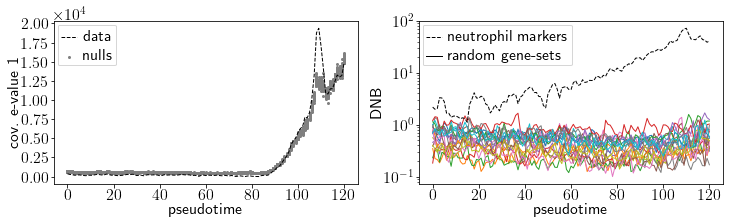

In [88]:
fig,axs=plt.subplots(1,2,figsize=(12,3))

cols = ['k','gray']

fs=16

axs[0].plot(pst_eig1_n,'--', label = 'data',markersize=1, color=cols[0])
axs[0].scatter(pst_null_times,pst_null_flat, color=cols[1], label='nulls')
#axs[0].set_yscale('log')
axs[0].set_ylabel('cov. e-value 1', linespacing=1)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].yaxis.get_offset_text().set_fontsize(fs)


axs[1].plot(dnb_biom_rand[0:20].T)
axs[1].plot(dnb_biom,'k--',label='neutrophil markers')
axs[1].plot(0,0,'k-',label='random gene-sets')

axs[1].set_yscale('log')
axs[1].set_ylabel('DNB')
axs[1].legend()

plt.subplots_adjust(wspace=0.2)

for ax in axs:
    ax.set_xlabel('pseudotime')
    mf.set_axs_fontsize(ax,fs,True)

plt.savefig('{0}/fig4_null_sup.pdf'.format(figdir), bbox_inches='tight')


In [38]:
dnb_rand_mu = np.mean(dnb_biom_rand, axis=0)
dnb_rand_std = np.std(dnb_biom_rand, axis=0)
dnb_rand_err = dnb_rand_std / np.sqrt(dnb_biom_rand.shape[0])

In [37]:
dnb_biom_rand.shape

(100, 121)

In [ ]:
# intentionally left blank

In [398]:
# In[24]:

###############################################################
# In[33]: schematic
###############################################################
print('loading schematic')
haem_dev_schem = plt.imread('pngs/neut_tree.png')
schem_dy, schem_dx, _ = haem_dev_schem.shape



###############################################################
# type densities
###############################################################
print('cluster label in pseudotime')
types_per_group_neut = [ctype_idxs[np.array(grp,dtype='int')] for grp in neut_pst_cidxs] 
type_bins            = np.arange(-0.5,len(ctypes)+0.5,1)
type_denss_neut      = np.array([
    np.histogram(grp, bins=type_bins, density=True)[0] if len(grp)>0 else blank_hist 
    for grp in types_per_group_neut])


# In[25]:


###############################################################
# marker gene expression
###############################################################

# In[26]:

print('marker gene expression')
gene_group_labs  = ['neutrophil','MPP','GPP','PMy','My']

neut_gnms        = np.array(['S100a9', 'Itgb2l', 'Elane', 'Fcnb', 'Mpo', 'Prtn3', 
                              'S100a6', 'S100a8', 'Lcn2', 'Lrg1'])
mpp_gnms         = np.array(['Ly6a','Meis1','Flt3','Cd34'])
gmp_gnms         = np.array(['Csf1r','Cebpa'])
pmy_gnms         = np.array(['Gfi1','Elane'])
my_gnms          = np.array(['S100a8','Ngp','Ltf'])

grp_gnms  = [neut_gnms, mpp_gnms, gmp_gnms, pmy_gnms, my_gnms]

grp_gidxs = [np.array([np.where(gnms==gnm)[0][0] for gnm in k]) for k in grp_gnms]


# In[27]:


# grp_gexp = [[np.hstack([gexp_lil[cidxs, k].toarray() for k in grp]) 
#              for cidxs in neut_pst_cidxs]
#             for grp in grp_gidxs]
with open('{0}/marker_gene_trajs.pkl'.format(datdir), 'rb') as f:
    grp_gexp = pkl.load(f)
# save grp_gexp!

# In[28]:


grp_mu_gexp   = [np.array([np.mean(grp_gexp[i][t],axis=0) for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]
grp_std_gexp  = [np.array([np.std(grp_gexp[i][t],axis=0) for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]
grp_sem_gexp  = [np.array([grp_std_gexp[i][:,t]/np.sqrt(grp_gexp[i][t].shape[1]) 
                           for t in range(len(grp_gexp[i]))]).T
                         for i in range(len(grp_gexp))]

loading schematic
cluster label in pseudotime
marker gene expression


making figure 5
saved fig 5


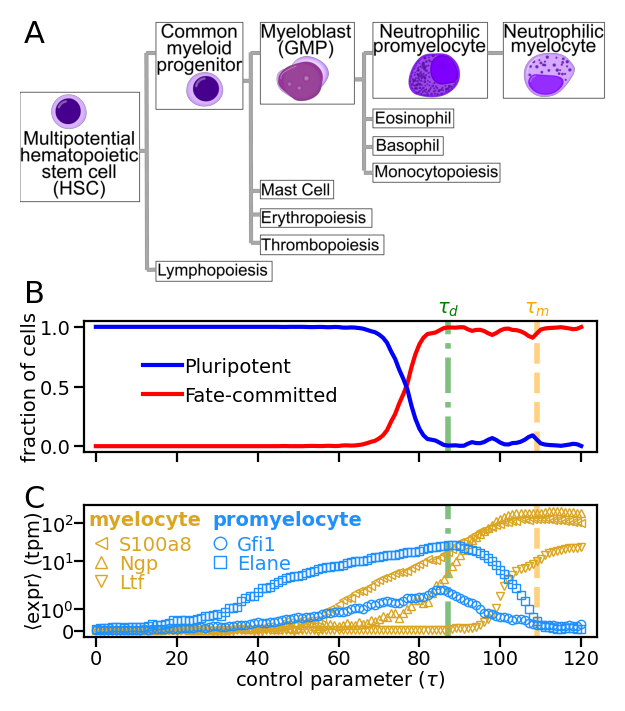

In [80]:
###############################################################
# In[127]: fig 5 ##############################################
###############################################################

print('making figure 5')

plt.style.reload_library()
plt.style.use('one_col_fig')

matplotlib.rcParams.update({'font.size': 7,
                            'axes.titlesize':7, 
                            'axes.labelsize':7,
                            'xtick.labelsize':7,
                           'ytick.labelsize':7,
                           'legend.fontsize':7})
taulims = [-3,124]

marg_ht = 1
#schem_ht = 6
tau_series_ht = 8
spc1_ht = 3
spc2_ht = 3

marg_wd = 1
tau_series_wd = 30

wds = np.array([
    marg_wd,
    tau_series_wd
])

wds = np.array(wds/np.min(wds),dtype='int')

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

schem_ht = int(schem_dy/schem_dx*nc)

# row heights
hts = np.array([
    
    marg_ht,
    schem_ht,   
    spc1_ht,
    tau_series_ht,
    spc2_ht,
    tau_series_ht
    
])

hts = np.array(hts/np.min(hts),dtype='int')

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 8.7/2.54
ht  = wid*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[0]:rs[1],cs[0]:]) # neut_dev_schem
axB  = plt.subplot( gs[rs[2]:rs[3], cs[0]:]) # clusters
axC  = plt.subplot( gs[rs[4]:rs[5], cs[0]:]) # genes


caps = ['A','B','C']
ri   = [0,rs[2],rs[4]]
ci   = [0,0,0]
ys   = [1,4,2.5]
xs   = [-1.5,-1.5,-1.5]
for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], 
                x=xs[i],
                y=ys[i],fontsize=11,verticalalignment='top',horizontalalignment='right')
    cap_ax.axis('off')
    
#####################################
## A: neutrophil dev schematic     ##
#####################################
taulims = [-3,124]

axA.set_xticks([])
axA.set_yticks([])
axA.set_ylim(0,schem_dy)
axA.set_xlim(0,schem_dx)
axA.imshow(haem_dev_schem,extent=[-0.13*schem_dx,1.02*schem_dx,
                                  -0.08*schem_dy,1.07*schem_dy],clip_on=False)
#axA.imshow(haem_dev_schem)
#axA.margins(0)

axA.axis('off')

#####################################
## B: cell type fraction           ##
#####################################

cols = ['red','blue','green']
col_idx = 0
lab_dict = {'Undifferentiated':'Pluripotent','Neutrophil':'Fate-committed'}
for i in np.arange(len(ctypes)):
    if max(type_denss_neut[:,i]>=0.1):
        axB.plot(type_denss_neut[:,i], label=lab_dict[ctypes[i]], lw=1.5, color = cols[col_idx])
        col_idx += 1

axB.set_ylabel('fraction of cells', linespacing=1)
handles, labels = axB.get_legend_handles_labels()
leg = axB.legend(handles[::-1], labels[::-1],frameon=False, loc=(0.1,0.3), handletextpad=0.1)
axB.set_xticklabels([])
axB.set_xlim(*taulims)
axB.set_yticks([0,0.5,1])

#####################################
## C: myeloid gene expression      ##
#####################################

# other version which includes promyelocite genes
grps = [4,3]
cols = ['goldenrod','dodgerblue']
marks = [['<','^','v'],['o','s']]
msz = [3,3,3]
fs = ['none','none','none']

for i in range(len(grps)):
    mu_gexp = grp_mu_gexp[grps[i]]
    ggnms = grp_gnms[grps[i]]
    for g in range(mu_gexp.shape[0]):
        axC.plot(np.arange(npsts),mu_gexp[g], marker = marks[i][g],markersize=msz[i],
             color=cols[i], label=ggnms[g], fillstyle=fs[i], markeredgewidth=0.5,linestyle='none') 
    
axC.set_yscale('symlog')
#axC.set_yscale('log')
axC.tick_params(axis='y', which='major', pad=0)
leg = axC.legend(labelspacing=0,frameon=False, loc=(0,0.28),ncol=2,columnspacing=0.9, handlelength=1,
                handletextpad=0.4,markerscale=1.5)
axC.set_ylabel(r'$\langle$expr$\rangle$ (tpm)',labelpad=-2.5)

for i,text in zip(range(5),leg.get_texts()):
    plt.setp(text, color = cols[0] if i<len(marks[0]) else cols[1])

# both versions, x-axis
axC.set_xlim(*taulims)
axC.set_xlabel(r'control parameter ($\tau$)')
axC.text(s='myelocyte',x=0.01,y=0.85,color=cols[0],fontsize=7,fontweight='bold',transform=axC.transAxes)
axC.text(s='promyelocyte',x=0.25,y=0.85,color=cols[1],fontsize=7,fontweight='bold',transform=axC.transAxes)


bif_axs = [axB,axC]
zord = [0,0,1,0,0]
cols = ['orange','green']
bifts = np.array([t_bifurc,t_bifurc_pf])
lss = ['--','-.']
bifnms = [r'$\tau_{m}$',r'$\tau_{d}$']
bifxs = (bifts - taulims[0])/(taulims[1]-taulims[0]) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    axB.text(s=bifnms[j],x=bifxs[j],y=1.02,transform=axB.transAxes,color=cols[j],
             horizontalalignment = 'center', verticalalignment='bottom')
    for i in range(len(bif_axs)):
        bif_axs[i].axvline(bifts[j],color=cols[j], linestyle = lss[j], alpha=0.5,zorder=zord[i],lw=2)

plt.savefig('{0}/fig5_neut_gexp.pdf'.format(figdir), bbox_inches='tight')

print('saved fig 5')

In [ ]:
####### movie for twitter

In [90]:
import matplotlib.animation as animation
from matplotlib.animation import Animation, FuncAnimation

In [91]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [104]:
pst_sort = np.argsort(neut_psts[:,1])

In [107]:
neut_psts.shape[0]

61310

In [144]:
def adjust_yerr(err, y_error):
    ln, (err_top, err_bot), (bars, ) = err
    y_base = ln.get_ydata()
    x_base = ln.get_xdata()

    yerr_top = y_base + y_error
    yerr_bot = y_base - y_error

    err_top.set_ydata(yerr_top)
    err_bot.set_ydata(yerr_bot)

    new_segments = [np.array([[x, yt], [x, yb]]) for
                    x, yt, yb in zip(x_base, yerr_top, yerr_bot)]

    bars.set_segments(new_segments)

In [181]:
def update_errorbar(errobj, x, y, xerr=None, yerr=None):
    ln, caps, bars = errobj


    if len(bars) == 2:
        assert xerr is not None and yerr is not None, "Your errorbar object has 2 dimension of error bars defined. You must provide xerr and yerr."
        barsx, barsy = bars  # bars always exist (?)
        try:  # caps are optional
            errx_top, errx_bot, erry_top, erry_bot = caps
        except ValueError:  # in case there is no caps
            pass

    elif len(bars) == 1:
        assert (xerr is     None and yerr is not None) or\
               (xerr is not None and yerr is     None),  \
               "Your errorbar object has 1 dimension of error bars defined. You must provide xerr or yerr."

        if xerr is not None:
            barsx, = bars  # bars always exist (?)
            try:
                errx_top, errx_bot = caps
            except ValueError:  # in case there is no caps
                pass
        else:
            barsy, = bars  # bars always exist (?)
            try:
                erry_top, erry_bot = caps
            except ValueError:  # in case there is no caps
                pass

    ln.set_data(x,y)

    try:
        errx_top.set_xdata(x + xerr)
        errx_bot.set_xdata(x - xerr)
        errx_top.set_ydata(y)
        errx_bot.set_ydata(y)
    except NameError:
        pass
    try:
        barsx.set_segments([np.array([[xt, y], [xb, y]]) for xt, xb, y in zip(x + xerr, x - xerr, y)])
    except NameError:
        pass

    try:
        erry_top.set_xdata(x)
        erry_bot.set_xdata(x)
        erry_top.set_ydata(y + yerr)
        erry_bot.set_ydata(y - yerr)
    except NameError:
        pass
    try:
        barsy.set_segments([np.array([[x, yt], [x, yb]]) for x, yt, yb in zip(x, y + yerr, y - yerr)])
    except NameError:
        pass

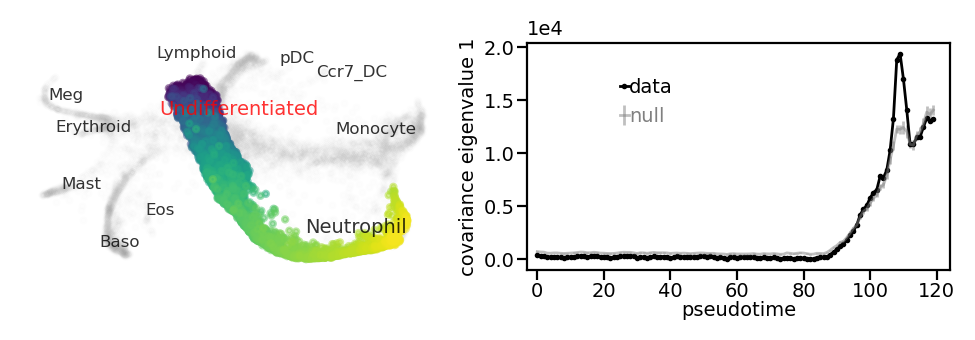

In [185]:
scat  = axA.scatter([],[], c=[],alpha=0.5)
eig1, = axC.plot([],[],'o-', label = 'data',markersize=1, color=cols[0])
null  = axC.errorbar([],[], yerr=[], color=cols[1], capsize=2,alpha=0.5, label='null')
lines = [scat, eig1, null[0]]

axC.set_ylim(np.min(pst_eig1_n)-1000,np.max(pst_eig1_n)+1000)
axC.legend(loc = (0.2,0.6),frameon=False,handlelength=0.5,handletextpad=0,labelcolor=cols)

def update(tf):
    
    if 1<=tf<121:
        cellf=1000+500*(tf-1)
    elif tf<1:
        cellf=0
    else:
        cellf=traj_idxs.shape[0]
        
    scat.set_offsets(np.vstack([
        metadata['SPRINGx'][traj_idxs_s[:cellf:skip]],
        metadata['SPRINGy'][traj_idxs_s[:cellf:skip]]
    ]).T)
    scat.set_color(traj_cols[:cellf:skip])
                     
    eig1.set_data(np.arange(tf),pst_eig1_n[0:tf])
    null[0].set_data(np.arange(tf),pst_grp_null_eval_mu[:tf])
    update_errorbar(null, np.arange(tf), pst_grp_null_eval_mu[:tf], yerr=pst_grp_null_eval_err[:tf])
    return lines
# run movie and save
ani = FuncAnimation(fig, update, frames=np.arange(pst_eig1_n.shape[0]),blit=True)#,init_func=init
ani.save('{0}/fig4_mov.jpg'.format(figdir), writer=writer)

making figure 4


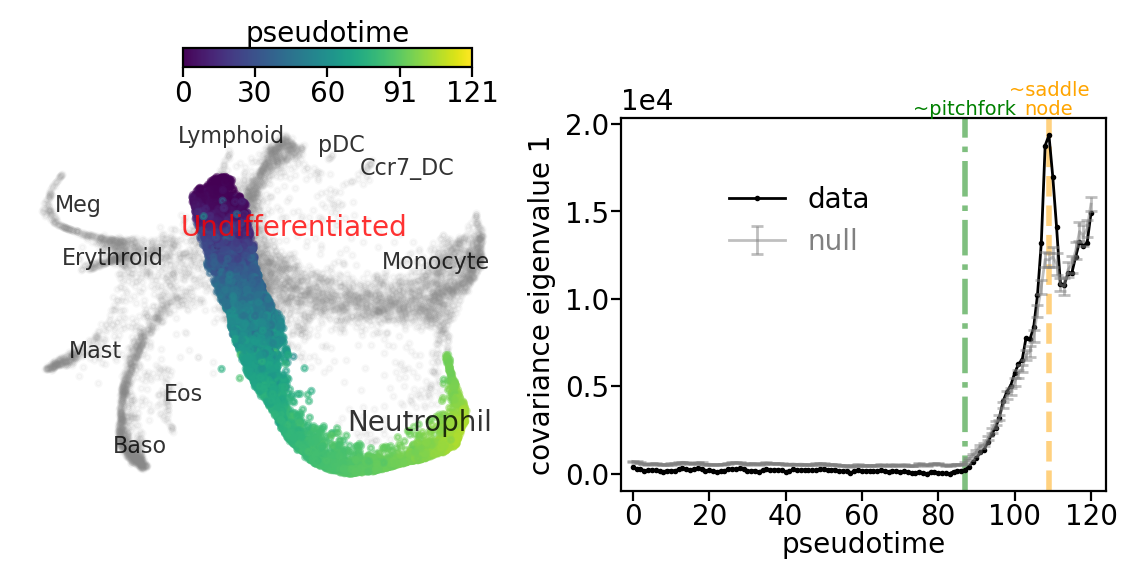

In [237]:
############################
#### fig 4 #################
############################
print('making figure 4')

plt.style.reload_library()
plt.style.use('one_col_fig')
matplotlib.rcParams.update({'font.size': 10,
                            'axes.titlesize':10, 
                            'axes.labelsize':10,
                            'xtick.labelsize':10,
                           'ytick.labelsize':10,
                           'legend.fontsize':10})
taulims = np.array([-3,124])

leg_ht  = 1
leg_spc = 2
spring_ht  = 16

col0_wd = 10
col1_wd = 18
col2_wd = 2
spc_wd  = 7
col3_wd = 30


wds = np.array([
    col0_wd,
    col1_wd,
    col2_wd,
    spc_wd,
    col3_wd
])

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

# row heights
hts = np.array([
    
    leg_ht,
    leg_spc,
    spring_ht
    
])

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 17.8/2.54
ht  = wid / 2.39 #*nr/nc

fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axAL = plt.subplot( gs[0    :rs[0], cs[0]:cs[1]]) # SPRING heat map legend
axA  = plt.subplot( gs[rs[1]:rs[2], 0:cs[2]]) # SPRING heat map

axC  = plt.subplot( gs[rs[1]:rs[2], cs[3]:cs[4]]) # covariance eigenvalue


#####################################
## A: SPRING plot                ####
#####################################
ab_cap_fs = 7
skip=10

# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.05)

#axA.set_xlim(springXlims[0],springXlims[1]+2500)
#axA.set_ylim(springYlims[0]-1500,springYlims[1])

# annotate cell types
ctype_offset = {'Monocyte':np.array([-500,200]),
               'Undifferentiated':np.array([-700,350]),
               'Lymphoid':np.array([-1300,100]),
                'pDC':np.array([-50,150]),
                'Erythroid':np.array([-400,0]),
               'Baso':np.array([-200,-400]),
               'Meg':np.array([-150,100])}

for i in range(len(ctypes)):
    axA.annotate(xy=ctype_mean_pos[i]+ctype_offset.get(ctypes[i],np.array([0,0])),
                 text=ctypes[i],alpha=0.8,
                 fontsize=10 if ctypes[i] in ['Undifferentiated', 'Neutrophil'] else 8, 
                 color='red' if ctypes[i]=='Undifferentiated' else 'black')
    
# plot points in neutrophil trajectory
skip = 5
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
        c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)

axA.set_xticks([])
axA.set_yticks([])

#frameless
axA.axis('off')

#colorbar
cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axAL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
#axAL.xaxis.tick_top()
axAL.set_xticklabels(np.array(np.around(np.linspace(0,npsts,nticks)),dtype='int'))
axAL.set_title(r'pseudotime')

#####################################
## C: covariance eigenvalue        ##
#####################################
xtix_all = np.array([0,20,40,60,80,100,120])
cols = ['k','gray']

axC.plot(pst_eig1_n,'o-', label = 'data',markersize=1, color=cols[0])
axC.errorbar(np.arange(npsts),pst_grp_null_eval_mu, yerr=pst_grp_null_eval_err, 
             color=cols[1], capsize=2,alpha=0.5, label='null')

axC.set_ylabel('covariance eigenvalue 1', linespacing=1, labelpad=3)
axC.legend(loc = (0.2,0.6),frameon=False,labelcolor=cols)

axC.set_xticks(xtix_all)
#axC.set_xticklabels([])
axC.set_xlabel('pseudotime')
axC.set_xlim(*taulims)
axC.set_yticks([0,5000,10000,15000,20000])

axC.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

bif_axs = [axC]
zord = [0,0,1,0,0]
cols = ['orange','green']
bifts = np.array([t_bifurc,t_bifurc_pf])
lss = ['--','-.']
bifnms = [r'$\tau_{m}$',r'$\tau_{d}$']
bifnms = '~saddle\nnode','~pitchfork'
bifxs = (bifts - taulims[0])/(taulims[1]-taulims[0]) #[0.8,0.6] #bifts / tf
for j in range(len(bifts)):
    axC.text(s=bifnms[j],x=bifxs[j],y=1,transform=axC.transAxes,color=cols[j],
             horizontalalignment = 'center', verticalalignment='bottom',fontsize=7,linespacing=1)
    for i in range(len(bif_axs)):
        bif_axs[i].axvline(bifts[j],color=cols[j], linestyle = lss[j], alpha=0.5,zorder=zord[i],lw=2)
plt.savefig('{0}/fig4_preview_ar.jpg'.format(figdir), bbox_inches='tight')


making figure 4


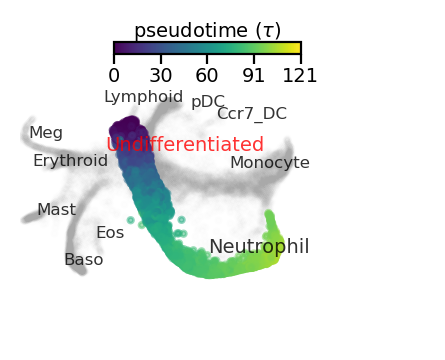

In [10]:
# just 4a
############################
#### fig 4 #################
############################
print('making figure 4')

plt.style.reload_library()
plt.style.use('one_col_fig')
matplotlib.rcParams.update({'font.size': 7,
                            'axes.titlesize':7, 
                            'axes.labelsize':7,
                            'xtick.labelsize':7,
                           'ytick.labelsize':7,
                           'legend.fontsize':7})
taulims = np.array([-3,124])

leg_ht  = 2
leg_spc = 7
spc1_ht  = 10
spc2_ht = 7
spc3_ht  = 7
spc1 = 1
schem1_ht   = 30
tseries_ht = 20
tau_series_ht = 25

col1_wd = 30
col2_wd = 20
spc_wd = 20
spc2_wd=1
spc3_wd=15

wds = np.array([
    spc3_wd,
    col1_wd,
    spc_wd,
    col2_wd-spc2_wd-leg_ht,
    spc2_wd,
    leg_ht
])

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

# row heights
hts = np.array([
    
    leg_ht,
    leg_spc,
    
    schem1_ht,   
    spc1_ht,
    spc2_ht,
    
    tau_series_ht,
    spc3_ht,
    tau_series_ht
    
])

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 8.7/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axAL = plt.subplot( gs[0    :rs[0], cs[0]:cs[1]]) # SPRING heat map legend
axA  = plt.subplot( gs[rs[1]:rs[3],0:cs[2]]) # SPRING heat map

#####################################
## A: SPRING plot                ####
#####################################
ab_cap_fs = 7
skip=5

# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.01)

axA.set_xlim(springXlims[0],springXlims[1]+2500)
axA.set_ylim(springYlims[0]-1500,springYlims[1])

# annotate cell types
ctype_offset = {'Monocyte':np.array([-500,200]),
               'Undifferentiated':np.array([-700,350]),
               'Lymphoid':np.array([-1300,100]),
                'pDC':np.array([-50,150]),
                'Erythroid':np.array([-400,0]),
               'Baso':np.array([-200,-400]),
               'Meg':np.array([-150,100])}

for i in range(len(ctypes)):
    axA.annotate(xy=ctype_mean_pos[i]+ctype_offset.get(ctypes[i],np.array([0,0])),
                 text=ctypes[i],alpha=0.8,
                 fontsize=7 if ctypes[i] in ['Undifferentiated', 'Neutrophil'] else 6, 
                 color='red' if ctypes[i]=='Undifferentiated' else 'black')
    
# plot points in neutrophil trajectory
skip = 10
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
        c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)

axA.set_xticks([])
axA.set_yticks([])

#frameless
axA.axis('off')

#colorbar
cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
sm     = plt.cm.ScalarMappable(cmap=cmap)
nticks = 5
plt.colorbar(sm, cax=axAL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
#axAL.xaxis.tick_top()
axAL.set_xticklabels(np.array(np.around(np.linspace(0,npsts,nticks)),dtype='int'), fontsize=ab_cap_fs)
axAL.set_title(r'pseudotime ($\tau$)', fontsize=ab_cap_fs)

plt.savefig('{0}/fig4A.jpg'.format(figdir), bbox_inches='tight')

making figure 4


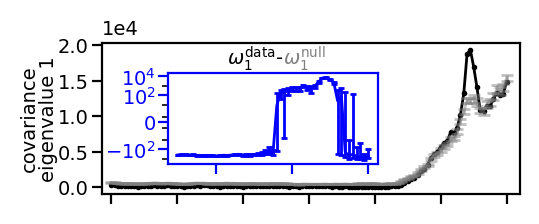

In [12]:
############################
#### fig 4 #################
############################
print('making figure 4')

plt.style.reload_library()
plt.style.use('one_col_fig')
matplotlib.rcParams.update({'font.size': 7,
                            'axes.titlesize':7, 
                            'axes.labelsize':7,
                            'xtick.labelsize':7,
                           'ytick.labelsize':7,
                           'legend.fontsize':7})
taulims = np.array([-3,124])

leg_ht  = 2
leg_spc = 7
spc1_ht  = 10
spc2_ht = 7
spc3_ht  = 7
spc1 = 1
schem1_ht   = 30
tseries_ht = 20
tau_series_ht = 25

col1_wd = 30
col2_wd = 20
spc_wd = 20
spc2_wd=1
spc3_wd=15

wds = np.array([
    spc3_wd,
    col1_wd,
    spc_wd,
    col2_wd-spc2_wd-leg_ht,
    spc2_wd,
    leg_ht
])

cs = np.cumsum(wds) # starting cols 
nc = np.sum(wds)

# row heights
hts = np.array([
    
    leg_ht,
    leg_spc,
    
    schem1_ht,   
    spc1_ht,
    spc2_ht,
    
    tau_series_ht,
    spc3_ht,
    tau_series_ht
    
])

rs = np.cumsum(hts) # starting rows
nr = np.sum(hts)

wid = 8.7/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=200) 

gs = gridspec.GridSpec(nr, nc)

axC  = plt.subplot( gs[rs[4]:rs[5], cs[0]:cs[3]]) # covariance eigenvalue

#####################################
## C: covariance eigenvalue        ##
#####################################
xtix_all = np.array([0,20,40,60,80,100,120])
cols = ['k','gray']

axC.plot(pst_eig1_n,'o-', label = 'data',markersize=1, color=cols[0])
axC.errorbar(np.arange(npsts),pst_grp_null_eval_mu, yerr=pst_grp_null_eval_err, 
             color=cols[1], capsize=2,alpha=0.5, label='null')

axC.set_ylabel('covariance\neigenvalue 1', linespacing=1)
# leg = axC.legend(loc = (0.7,0.6),labelspacing=0,frameon=False,handlelength=0.5,handletextpad=0)
# for i,text in zip(range(len(cols)),leg.get_texts()):
#     plt.setp(text, color = cols[i])

axC.set_xticks(xtix_all)
axC.set_xticklabels([])
axC.set_xlim(*taulims)
axC.set_yticks([0,5000,10000,15000,20000])

axC.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

### inset ###
axCin = axC.inset_axes([0.16, 0.2, 0.5, 0.6],transform=axC.transAxes)
ti=70
tf=121

col = 'blue'
axCin.errorbar(np.arange(ti,tf),pst_eig1_n[ti:tf]-pst_grp_null_eval_mu[ti:tf],
               yerr=pst_grp_null_eval_err[ti:tf],
               color=col, capsize=1)
axCin.set_yscale('symlog')
axCin.set_yticks([-100,0,100,10000])

difftxts = [r'${\omega_1^{\rm data}}$-', r'${\omega_1^{\rm null}}$']

halines = ['right','left']
for i in range(len(difftxts)):
    axCin.text(x=0.55,y=1.01,s=difftxts[i],color=cols[i],horizontalalignment = halines[i],
               transform=axCin.transAxes, verticalalignment='bottom')

axCin.set_xticks(xtix_all[np.where(xtix_all>ti)])
axCin.set_xticklabels([])

plt.setp(axCin.spines.values(), color=col)
plt.setp([axCin.get_xticklines(), axCin.get_yticklines()], color=col)
axCin.tick_params(color=col, labelcolor=col)

plt.savefig('{0}/fig4C.jpg'.format(figdir), bbox_inches='tight')

In [5]:
pst_pc1.shape

(121, 25289)

In [7]:
t_bifurc    = np.argmax(pst_eig1)

In [9]:
pc1_projs = pst_pc1.dot(pst_pc1[t_bifurc])

In [10]:
pc1_projs.shape

(121,)

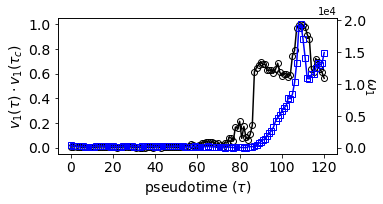

In [28]:
fig,axs=plt.subplots(figsize=(5,2.5))
axs.plot(np.abs(pc1_projs),'ko-',fillstyle='none')
ax2 = axs.twinx()
ax2.plot(pst_eig1_n,'bs-',fillstyle='none')
axs.set_xlabel(r'pseudotime ($\tau$)')
axs.set_ylabel(r'$v_1(\tau)\cdot v_1(\tau_c)$')
ax2.set_ylabel(r'$\omega_1$',rotation=270, labelpad=10)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

mf.set_axs_fontsize(axs,14)
mf.set_axs_fontsize(ax2,14)

In [13]:
pst_pc1.shape
mu_gexp.shape

(121, 25289)

In [15]:
mu_proj = pst_pc1.dot(mu_gexp.T)

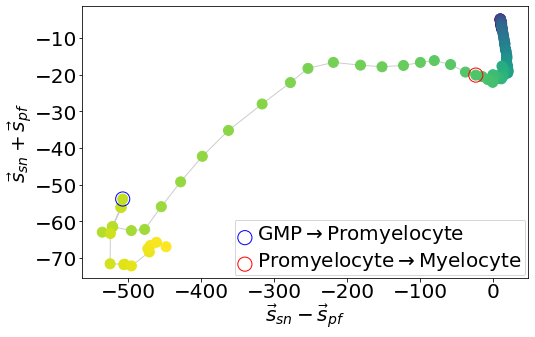

In [89]:
tms = copy.copy(bifts)

ax1 = pst_pc1[tms[0]] - pst_pc1[tms[1]]
ax2 = pst_pc1[tms[0]] + pst_pc1[tms[1]]

ax1_proj = mu_gexp.dot(ax1)
ax2_proj = mu_gexp.dot(ax2)

fig,axs=plt.subplots(figsize=(8,5))

axs.plot(ax1_proj, ax2_proj,'ko-',zorder=0,alpha=0.2)
axs.scatter(ax1_proj, ax2_proj, color=cols, s=100,linestyle='-',zorder=1)

axs.scatter(ax1_proj[tms[0]],ax2_proj[tms[0]],s=200,color='None',edgecolor='blue',
            label=r'GMP$\rightarrow$Promyelocyte')
axs.scatter(ax1_proj[tms[1]],ax2_proj[tms[1]],s=200,color='None',edgecolor='red',
            label=r'Promyelocyte$\rightarrow$Myelocyte')

axs.legend()
axs.set_xlabel(r'$\vec{s}_{sn}-\vec{s}_{pf}$')
axs.set_ylabel(r'$\vec{s}_{sn}+\vec{s}_{pf}$')

#axs.set_ylabel(r'GMP$\rightarrow$Promyelocyte'+'\neigenvector')
mf.set_axs_fontsize(axs,20,True)

In [16]:
mu_proj.shape

(121, 121)

In [23]:
nt = mu_gexp.shape[0]

In [24]:
cols=plt.cm.viridis(np.linspace(0,1,nt))


In [44]:
mu_proj[bifts[0],bifts[0]],mu_proj[bifts[0],bifts[1]],mu_proj[bifts[1],bifts[0]],mu_proj[bifts[1],bifts[1]]

(-280.8664205847266,
 -21.745051523746643,
 226.97144897445895,
 1.6552557155702043)

In [62]:
copy.copy(bifts)

array([109,  87])

ValueError: 'c' argument has 69577 elements, which is inconsistent with 'x' and 'y' with size 121.

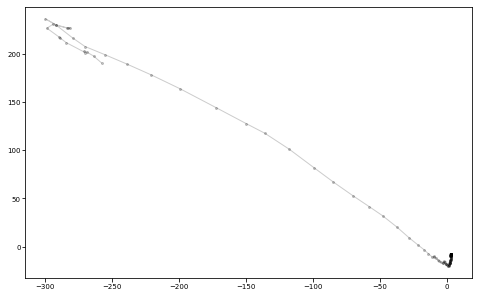

In [115]:
tms = copy.copy(bifts)

fig,axs=plt.subplots(figsize=(8,5))

axs.plot(mu_proj[tms[0]], mu_proj[tms[1]],'ko-',zorder=0,alpha=0.2)
axs.scatter(mu_proj[tms[0]], mu_proj[tms[1]],color=cols, s=100,linestyle='-',zorder=1)

axs.scatter(mu_proj[tms[0],tms[1]],mu_proj[tms[1],tms[1]],s=200,color='None',edgecolor='blue',
            label=r'GMP$\rightarrow$Promyelocyte')
axs.scatter(mu_proj[tms[0],tms[0]],mu_proj[tms[1],tms[0]],s=200,color='None',edgecolor='red',
            label=r'Promyelocyte$\rightarrow$Myelocyte')

axs.legend()

axs.set_xlabel(r'Promyelocyte$\rightarrow$Myelocyte eigenvector')
axs.set_ylabel(r'GMP$\rightarrow$Promyelocyte'+'\neigenvector')
mf.set_axs_fontsize(axs,20,True)

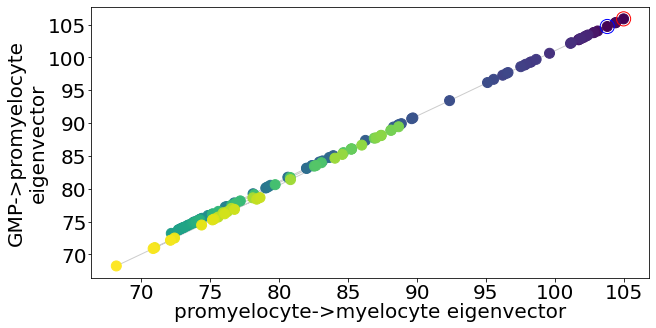

In [75]:
tms = np.array([0,1])
fig,axs=plt.subplots(figsize=(10,5))

axs.plot(mu_proj[tms[0]], mu_proj[tms[1]],'ko-',zorder=0,alpha=0.2)
axs.scatter(mu_proj[tms[0]], mu_proj[tms[1]],color=cols, s=100,linestyle='-',zorder=1)

axs.scatter(mu_proj[tms[0],tms[0]],mu_proj[tms[1],tms[0]],s=200,color='None',edgecolor='red')
axs.scatter(mu_proj[tms[0],tms[1]],mu_proj[tms[1],tms[1]],s=200,color='None',edgecolor='blue')

axs.set_xlabel('promyelocyte->myelocyte eigenvector')
axs.set_ylabel('GMP->promyelocyte\neigenvector')
mf.set_axs_fontsize(axs,20)

In [ ]:
ti=70
ti+np.where(pst_eig1_n[ti:tf]-pst_grp_null_eval_mu[ti:tf]>0)[0]

In [73]:
bifts2=[109,96]

array([109,  87])

In [91]:
print('loading gene expression matrix')
gexp_fname = '{0}/gene_expr.npz'.format(datdir)
gexp_sp    = scipy.sparse.load_npz(gexp_fname) # WT: 18.3 seconds
gexp_lil   = gexp_sp.tolil() # WT: 3 min 55 seconds

loading gene expression matrix


In [92]:
gexp_lil.shape

(130887, 25289)

In [93]:
pst_pc1.shape

(121, 25289)

In [98]:
gexp_pc1_proj = gexp_sp.dot(pst_pc1.T)

In [97]:
gexp_sp.shape, pst_pc1.shape

((130887, 25289), (121, 25289))

In [99]:
gexp_pc1_proj.shape

(130887, 121)

In [100]:
np.save('{0}/gexp_pc1_proj.npy'.format(datdir),gexp_pc1_proj)

In [101]:
bifts

array([109,  87])

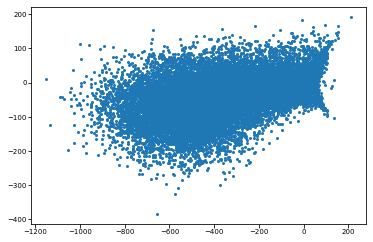

In [106]:
fig,axs=plt.subplots()
skip = 1
axs.plot(gexp_pc1_proj[::skip,bifts[0]]-gexp_pc1_proj[::skip,bifts[1]], 
         gexp_pc1_proj[::skip,bifts[0]]+gexp_pc1_proj[::skip,bifts[1]],
        'o')

In [107]:
v1 = gexp_pc1_proj[:,bifts[0]]-gexp_pc1_proj[:,bifts[1]]
v2 = gexp_pc1_proj[:,bifts[0]]+gexp_pc1_proj[:,bifts[1]]

In [261]:
gexp_pc1_proj.shape

(130887, 121)

In [109]:
metadata['SPRINGx'].shape

(130887,)

In [150]:
keys = metadata['Cell_type_annotation']
#keys = full_annot
#keys = metadata['Library_Cell']
ctypes         = np.unique(keys)
ctype_idx_dict = dict(zip(ctypes,range(ctypes.shape[0])))
ctype_idxs     = np.array([ctype_idx_dict[k] for k in keys])

In [153]:
ctype_idxs_split = [np.where(ctype_idxs==i)[0] for i in range(len(ctypes))]

In [156]:
ctypes

array(['Baso', 'Ccr7_DC', 'Eos', 'Erythroid', 'Lymphoid', 'Mast', 'Meg',
       'Monocyte', 'Neutrophil', 'Undifferentiated', 'pDC'], dtype='<U60')

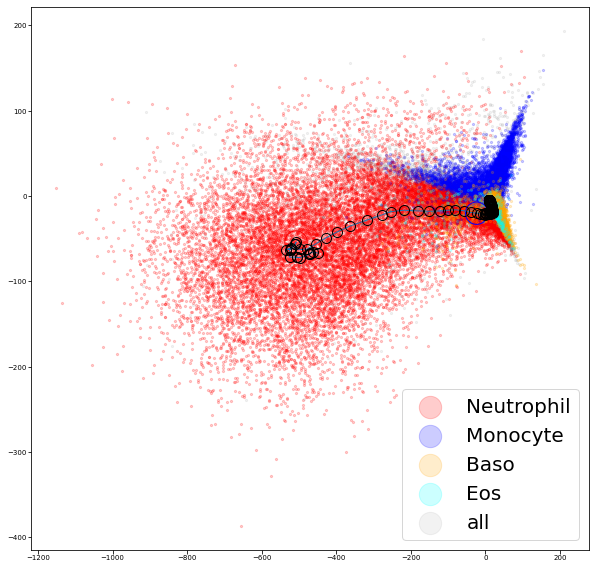

In [225]:
fig,axA = plt.subplots(figsize=(10,10))
traj_idxs = np.array(neut_psts[:,0],dtype='int')
#idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
skip=1

#springXlims = [np.amin(v1[idxs[::skip]]),np.amax(v2[idxs[::skip]])]
#springYlims = [np.amin(v1[idxs[::skip]]),np.amax(v2[idxs[::skip]])]


types2plot = ['Neutrophil','Monocyte','Baso','Eos']#,'Neutrophil']
type_cols = ['red','blue','orange','cyan']

idxs_rest = np.arange(metadata.shape[0])
for i in range(len(types2plot)):
    idxs = ctype_idxs_split[ctype_idx_dict[types2plot[i]]]
    axA.scatter(v1[idxs[::skip]],v2[idxs[::skip]], c=type_cols[i],alpha=0.2,zorder=1, s=5, label=types2plot[i])
    
    idxs_rest = np.setdiff1d(idxs_rest, idxs)

axA.scatter(v1[idxs_rest[::skip]],v2[idxs_rest[::skip]], c='gray',alpha=0.1,zorder=0, s=5, label='all')

axA.legend(fontsize=20, markerscale=10)#, labelcolor='mfc')
#axA.set_xlim(springXlims[0],springXlims[1]+2500)
#axA.set_ylim(springYlims[0]-1500,springYlims[1])

# # annotate cell types
# ctype_offset = {'Monocyte':np.array([0,0]),
#                'Undifferentiated':np.array([-700,350]),
#                'Lymphoid':np.array([-1300,100]),
#                 'pDC':np.array([-50,150]),
#                 'Erythroid':np.array([-400,0]),
#                'Baso':np.array([-200,-400]),
#                'Meg':np.array([-150,100])}

# for i in range(len(ctypes)):
#     axA.annotate(xy=ctype_mean_pos[i]+ctype_offset.get(ctypes[i],np.array([0,0])),
#                  text=ctypes[i],alpha=0.8,
#                  fontsize=7 if ctypes[i] in ['Undifferentiated', 'Neutrophil'] else 6, 
#                  color='red' if ctypes[i]=='Undifferentiated' else 'black')
    
# plot points in neutrophil trajectory
skip = 10
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
#axA.scatter(v1[traj_idxs[::skip]],v2[traj_idxs[::skip]], 
#        c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1,s=50,zorder=0)

axA.scatter(ax1_proj[tms[1]],ax2_proj[tms[1]],s=500,color='None',edgecolor='blue',
            label=r'GMP$\rightarrow$Promyelocyte')
axA.scatter(ax1_proj[tms[0]],ax2_proj[tms[0]],s=500,color='None',edgecolor='red',
            label=r'Promyelocyte$\rightarrow$Myelocyte')
#axA.set_xticks([])
#axA.set_yticks([])

#frameless
#axA.axis('off')
axA.plot(ax1_proj, ax2_proj,'o-',zorder=1,alpha=1,markersize=10,markerfacecolor='None', markeredgecolor='black')

# #colorbar
# cmap   = plt.cm.get_cmap('viridis', traj_idxs.shape[0])
# sm     = plt.cm.ScalarMappable(cmap=cmap)
# nticks = 5
# plt.colorbar(sm, cax=axAL, orientation='horizontal',ticks=np.linspace(0,1,nticks))
# #axAL.xaxis.tick_top()
# axAL.set_xticklabels(np.array(np.around(np.linspace(0,npsts,nticks)),dtype='int'), fontsize=ab_cap_fs)
# axAL.set_title(r'pseudotime ($\tau$)', fontsize=ab_cap_fs)


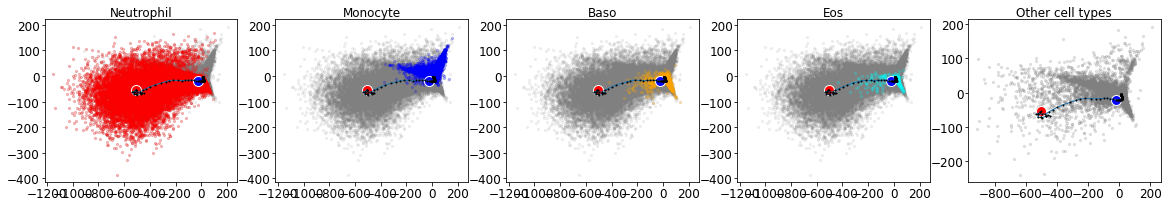

In [242]:
fig,axs = plt.subplots(1,5,figsize=(2))

skip=1
xlims = [-1300,300]
ylims = [-420,220]

types2plot = ['Neutrophil','Monocyte','Baso','Eos','Other cell types']
type_cols = ['red','blue','orange','cyan', 'gray']
nctypes = len(types2plot)-1
idxs_all = np.arange(metadata.shape[0])
idxs_rest = np.arange(metadata.shape[0])
for i in range(len(types2plot)):
    
    if i < nctypes:
        idxs = ctype_idxs_split[ctype_idx_dict[types2plot[i]]]
        idxs_rest = np.setdiff1d(idxs_rest, idxs)
        
        axs[i].scatter(v1[idxs_all[::skip]],v2[idxs_all[::skip]], c='gray',alpha=0.1,zorder=0, s=5, label='all')

    else:
        idxs = idxs_rest 
        
    axs[i].scatter(v1[idxs[::skip]],v2[idxs[::skip]], c=type_cols[i],alpha=0.2,zorder=1, s=5, label=types2plot[i])
    axs[i].set_title(types2plot[i])
    
    axs[i].scatter(ax1_proj[tms[1]],ax2_proj[tms[1]],s=100,facecolor='blue',edgecolor='white',
            label=r'GMP$\rightarrow$Promyelocyte')
    axs[i].scatter(ax1_proj[tms[0]],ax2_proj[tms[0]],s=100,facecolor='red',edgecolor='white',
            label=r'Promyelocyte$\rightarrow$Myelocyte')
    axs[i].plot(ax1_proj, ax2_proj,'o-',zorder=1,alpha=1,markersize=1,markerfacecolor='None', markeredgecolor='black')

    mf.set_axs_fontsize(axs[i], 12)

plt.show()

#axA.legend(fontsize=20, markerscale=10)#, labelcolor='mfc')

#for ax in axs

In [240]:
len(idxs_rest)

130332

In [165]:
pst_pc1.shape

(121, 25289)

In [167]:
pc1_corr = np.corrcoef(pst_pc1)

(121, 121)

In [190]:
nz_genes = [np.where(np.abs(x)>0)[0] for x in pst_pc1]

In [828]:
#[x.shape[0] for x in nz_genes]

In [ ]:
np.where()

In [194]:
npst=len(pst_pc1)

In [198]:
npst

121

In [202]:
pc1_corr_nz = np.zeros((npst, npst))
for i in range(npst):
    for j in range(i,npst):
        if j==i:
            pc1_corr_nz[i,j]=1
        else:
            evec_genes = np.intersect1d(nz_genes[i], nz_genes[j])
            pc1_corr_nz[i,j] = pst_pc1[i,evec_genes].dot(pst_pc1[j,evec_genes])
            pc1_corr_nz[j,i] = pc1_corr_nz[i,j]

In [205]:
np.amax(np.abs(pc1_corr - pc1_corr_nz))

2.220446049250313e-15

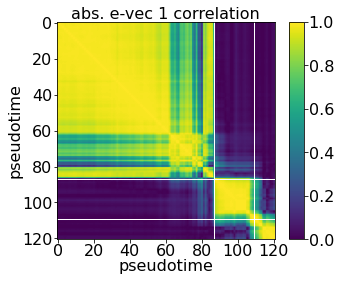

In [187]:
fig,axs=plt.subplots()
im = axs.imshow(np.abs(pc1_corr),vmin=0,vmax=1)

for t in bifts:
    axs.axvline(t, color='white')
    axs.axhline(t, color='white')
    
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="7%", pad=0.2)

plt.colorbar(im, cax=cax)


axs.set_title('abs. e-vec 1 correlation')
axs.set_xlabel('pseudotime')
axs.set_ylabel('pseudotime')
mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax,16)


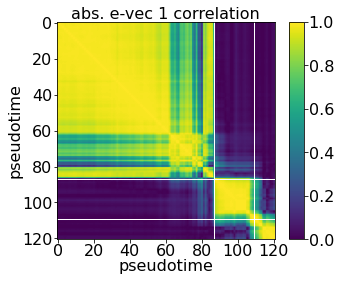

In [203]:
fig,axs=plt.subplots()
im = axs.imshow(np.abs(pc1_corr_nz),vmin=0,vmax=1)

for t in bifts:
    axs.axvline(t, color='white')
    axs.axhline(t, color='white')
    
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="7%", pad=0.2)

plt.colorbar(im, cax=cax)


axs.set_title('abs. e-vec 1 correlation')
axs.set_xlabel('pseudotime')
axs.set_ylabel('pseudotime')
mf.set_axs_fontsize(axs,16)
mf.set_axs_fontsize(cax,16)


In [ ]:
pc1_corr_nz

In [175]:
bifts

array([109,  87])

In [829]:
pst_pc1.shape

(121, 25289)

In [834]:
evec_ts = np.array([0,bifts[1],bifts[0]])

In [866]:
branch_cidxs_flat

[array([  8074,  74327,   7907, ..., 125876, 126012, 130358]),
 array([ 10374,  13674,  12703, ..., 129304, 129832, 130313])]

In [928]:
%matplotlib inline

In [871]:
5+3

8

In [872]:
neut_psts

array([[     0,  23849],
       [     3,  48995],
       [     5,  50719],
       ...,
       [130881,  48473],
       [130883,   9126],
       [130886,   1409]])

In [896]:
split_ts = [0,t0,bifts[0],nt]
traj_idxs_split = [np.hstack([neut_pst_cidxs[t] for t in range(split_ts[i],split_ts[i+1])]) 
                   for i in range(len(split_ts)-1)]
traj_idxs_split_branch = [traj_idxs_split[0]]+branch_cidxs_flat

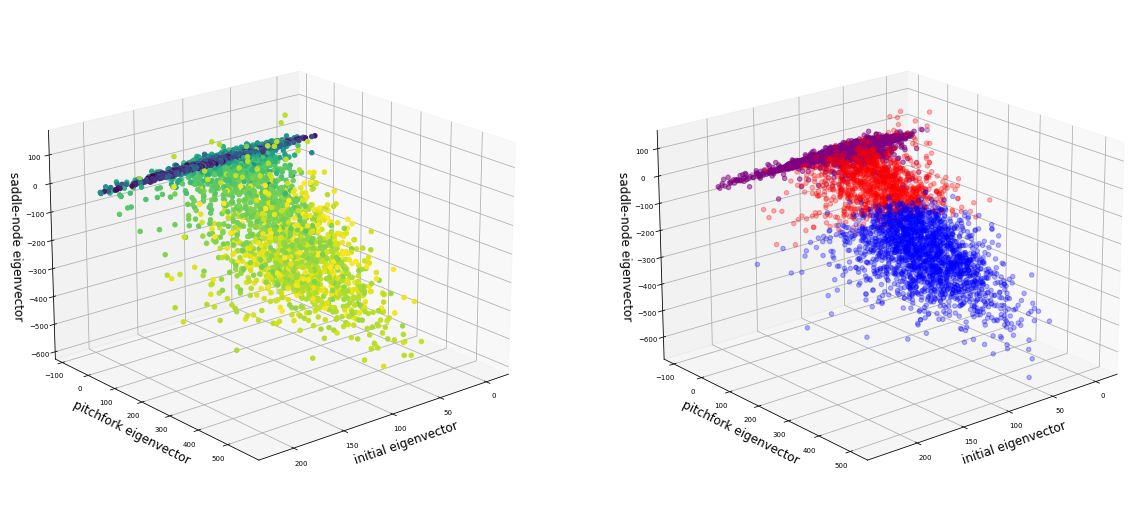

In [979]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(122, projection='3d')
#ax=plt.subplot(projection='3d')
skip = 1000

traj_idxs = np.array(neut_psts[:,0],dtype='int')
#idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
#springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
#springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
#axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.01)
    
# plot points in neutrophil trajectory
skip = 20
cols = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))
# ax.scatter(gexp_pc1_proj[::skip,evec_ts[0]],
#            gexp_pc1_proj[::skip,evec_ts[1]], 
#            gexp_pc1_proj[::skip,evec_ts[2]],
#           color='gray')

# ax.scatter(gexp_pc1_proj[traj_idxs[::skip],evec_ts[0]],
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[1]], 
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[2]],
#           c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1)

# gray blue red plot
# ax.scatter(gexp_pc1_proj[traj_idxs[::skip],evec_ts[0]],
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[1]], 
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[2]],
#           c='gray',alpha=0.5)
# ax.scatter(gexp_pc1_proj[branch_cidxs_flat[0][::skip],evec_ts[0]],
#            gexp_pc1_proj[branch_cidxs_flat[0][::skip],evec_ts[1]], 
#            gexp_pc1_proj[branch_cidxs_flat[0][::skip],evec_ts[2]],
#           c='blue',alpha=0.5)
# ax.scatter(gexp_pc1_proj[branch_cidxs_flat[1][::skip],evec_ts[0]],
#            gexp_pc1_proj[branch_cidxs_flat[1][::skip],evec_ts[1]], 
#            gexp_pc1_proj[branch_cidxs_flat[1][::skip],evec_ts[2]],
#           c='red',alpha=0.5)

cols = ['purple','blue','red']
skip = 10
for i in range(3):#len(traj_idxs_split)):
    proj = gexp_pc1_proj[traj_idxs_split_branch[i][::skip]][:,evec_ts].T
    ax.scatter(proj[0],proj[1],proj[2], c=cols[i],alpha=0.3)
    
#, fontsize=14, rotation=270)
#ax.tick_params(axis='z',fontsize=14)
#ax.zaxis._axinfo['tick']['fontsize']=20

#mf.set_axs_fontsize(ax, 14)

cols = plt.cm.viridis(np.linspace(0,1,traj_idxs.shape[0]))
ax2 = fig.add_subplot(121, projection='3d')
proj = gexp_pc1_proj[traj_idxs[::skip]][:,evec_ts].T
ax2.scatter(proj[0],proj[1],proj[2], c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1)

fs=12
for a in [ax, ax2]:
    a.set_xlabel('initial eigenvector', fontsize=fs)
    a.set_ylabel('pitchfork eigenvector', fontsize=fs)
    a.set_zlabel('saddle-node eigenvector', fontsize=fs)
    a.view_init(20, 50)

# ax.scatter(gexp_pc1_proj[traj_idxs[::skip],evec_ts[0]],
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[1]], 
#            gexp_pc1_proj[traj_idxs[::skip],evec_ts[2]],
#           c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=1)


# ax.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
#         c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5)


<ipython-input-957-6d1e24f882fc>:14: UserWarning: The following kwargs were not used by contour: 'color'
  CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
<ipython-input-957-6d1e24f882fc>:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xig, yig, zi,


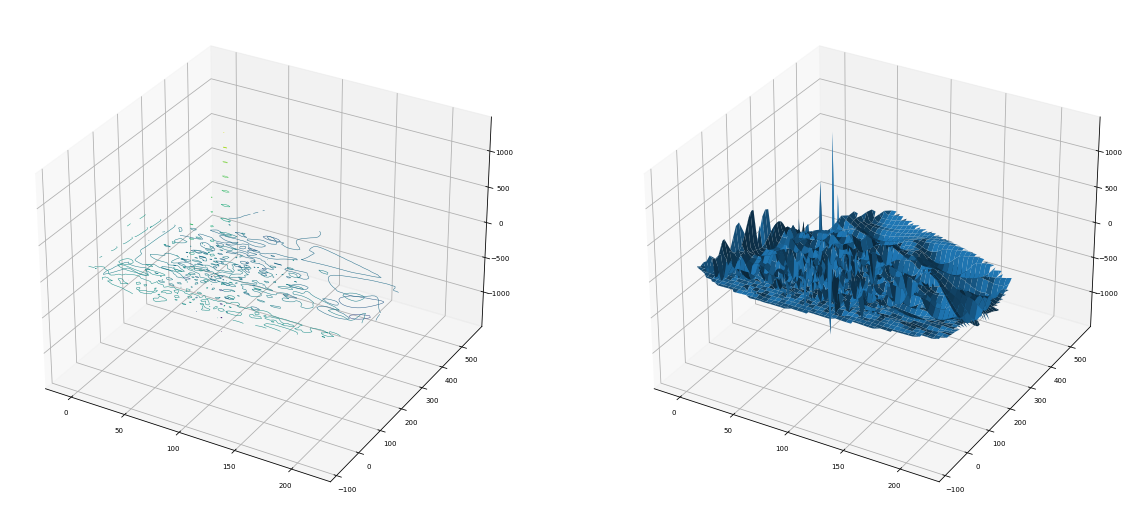

In [957]:
fig = plt.figure(figsize=(20,10))#plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
# note this: you can skip rows!
#my_data = np.genfromtxt('file1.csv', delimiter=',',skiprows=1)
X = proj[0]
Y = proj[1]
Z = proj[2]

xi = np.linspace(X.min(),X.max(),100)
yi = np.linspace(Y.min(),Y.max(),100)
# VERY IMPORTANT, to tell matplotlib how is your data organized
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
ax = fig.add_subplot(1, 2, 2, projection='3d')

xig, yig = np.meshgrid(xi, yi)

surf = ax.plot_surface(xig, yig, zi,
        linewidth=0)

plt.show()

In [887]:
gexp_pc1_proj[traj_idxs_split[i][::skip],evec_ts].shape

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4500,) (3,) 

In [831]:
evecs.shape

(3, 25289)

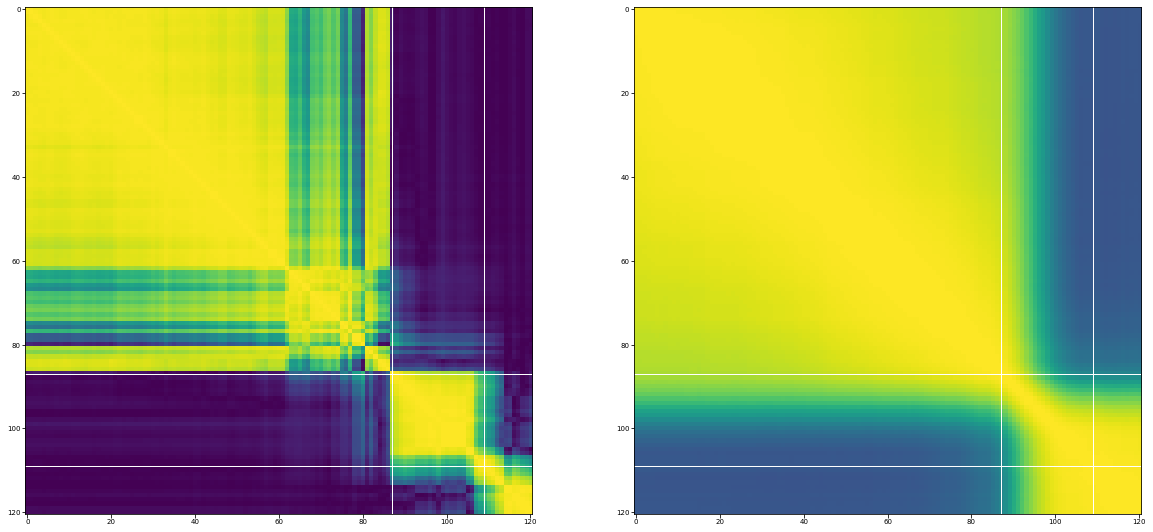

In [984]:
fig,axs=plt.subplots(1,2,figsize=(20,10))
im = axs[0].imshow(np.abs(pc1_corr_nz),vmin=0,vmax=1)
im2 = axs[1].imshow(mu_gexp_cc,vmin=0,vmax=1)

for t in bifts:
    for ax in axs:
        ax.axvline(t, color='white')
        ax.axhline(t, color='white')
    
# divider = make_axes_locatable(axs)
# cax = divider.append_axes("right", size="7%", pad=0.2)

# plt.colorbar(im, cax=cax)


# axs.set_title('abs. e-vec 1 correlation')
# axs.set_xlabel('pseudotime')
# axs.set_ylabel('pseudotime')
# mf.set_axs_fontsize(axs,16)
# mf.set_axs_fontsize(cax,16)


In [263]:
bifts[1]

87

In [269]:
pf_bif_proj_pst = [gexp_pc1_proj[cidx_grp,bifts[1]] for cidx_grp in neut_pst_cidxs]

In [352]:
hmaxs = np.array([np.amax(gexp_pc1_proj[:,bift]) for bift in bifts])
hmins = np.array([np.amin(gexp_pc1_proj[:,bift]) for bift in bifts])
nbins = 20
hbins = np.array([np.linspace(hmins[i], hmaxs[i]*1.001,nbins) for i in range(len(bifts))])
sgns = np.array([1,-1])
hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
bif_proj_hists = np.array([[np.histogram(sgns[i]*gexp_pc1_proj[neut_pst_cidxs[t],bifts[i]], bins=hbins[i])[0] 
                            for t in range(npst)] 
                          for i in range(len(bifts))])
hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

<ipython-input-353-68162f099450>:2: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(bif_proj_hists[1]).T,aspect='auto',zorder=1)
<ipython-input-353-68162f099450>:3: RuntimeWarning: divide by zero encountered in log10
  axs[1].imshow(np.log10(bif_proj_hists[0]).T,aspect='auto',zorder=1)


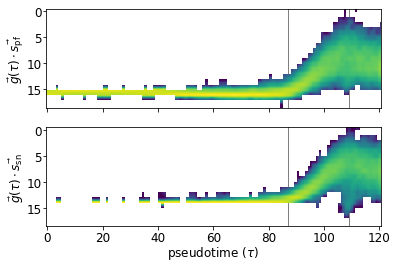

In [353]:
fig,axs = plt.subplots(2,1)
axs[0].imshow(np.log10(bif_proj_hists[1]).T,aspect='auto',zorder=1)
axs[1].imshow(np.log10(bif_proj_hists[0]).T,aspect='auto',zorder=1)

for t in bifts:
    for ax in axs:
        ax.axvline(t, color='gray',zorder=0)

        
for ax in axs:
    mf.set_axs_fontsize(ax,12)

axs[0].set_xticklabels([])
axs[1].set_xlabel(r'pseudotime ($\tau$)')

ylabs = [r'$\vec{g}(\tau)\cdot\vec{s_{\rm pf}}$',r'$\vec{g}(\tau)\cdot\vec{s_{\rm sn}}$']
for i,ax in enumerate(axs):
    ax.set_ylabel(ylabs[i])

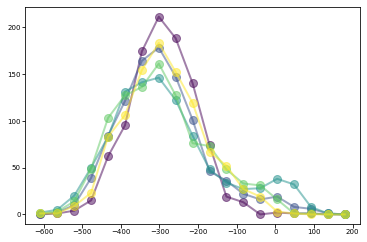

In [360]:
fig,axs=plt.subplots()
ts = np.arange(105,115,2)
cols = plt.cm.viridis(np.linspace(0,1,len(ts)))
for t in np.arange(len(ts)):
    #axs.step(hbin_mids[0], bif_proj_hists[0,ts[t]], color = cols[t], linewidth=2,alpha=1)
    axs.plot(hbin_mids[0], bif_proj_hists[0,ts[t]], 'o-',color = cols[t], linewidth=2,alpha=0.5,markersize=8)

In [362]:
from sklearn.mixture import GaussianMixture as GMM

In [368]:
dat   = gexp_pc1_proj[neut_pst_cidxs[bifts[0]],bifts[0]].reshape(-1,1)
mygmm = GMM(n_components=2).fit(dat)

In [463]:
t=0
dat  = gexp_pc1_proj[neut_pst_cidxs[t],bifts[0]].reshape(-1,1)

In [466]:
gmm_preds = [mygmm.predict(gexp_pc1_proj[neut_pst_cidxs[t],bifts[0]].reshape(-1,1)) for t in np.arange(nt)]

In [472]:
gmm_pred_idxs = [[np.where(gmm_preds[t]==i)[0] for i in range(2)] for t in range(nt)]

In [485]:
gmm_cov_eval_1 = np.array([
    PCA(n_components=1).fit(gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][1]]].toarray()).explained_variance_
    for t in range(nt)])

In [1]:
#[x[0].shape for x in gmm_pred_idxs]


In [496]:
gmm_cov_eval_0 = np.array([
    PCA(n_components=1).fit(gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][0]]].toarray()).explained_variance_[0]
    if gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][0]]].shape[0]>1
else np.nan
    for t in range(nt)
    
])

In [792]:
ngene = gexp_lil.shape[1]
t0    = np.where(nc1<1000)[0][0]
branch_cov_eval = np.zeros((nbranch, nt-t0))
branch_cov_evec = np.zeros((nbranch, nt-t0, ngene))
for i in range(nbranch):
    for t in range(t0, nt):
        mod = PCA(n_components = 1)
        modfit = mod.fit(gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][i]]].toarray())
        branch_cov_eval[i,t-t0] = modfit.explained_variance_
        branch_cov_evec[i,t-t0] = modfit.components_[0]

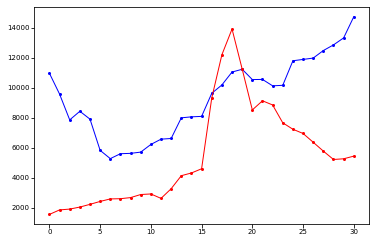

In [798]:
fig,axs=plt.subplots()
cols = ['blue', 'red']
for i in range(nbranch):
    axs.plot(branch_cov_eval[i], 'o-',color=cols[i])

In [801]:
bif_evec2 = branch_cov_evec[1,np.argmax(branch_cov_eval[1])]
bif_evec_proj = [gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][1]]].toarray().dot(bif_evec2) for t in range(t0,nt)]

In [811]:
bif_evec_proj_flat = np.hstack(bif_evec_proj)
nbins = 20
bmin = np.amin(bif_evec_proj_flat)
bmax = np.amax(bif_evec_proj_flat)*1.01
bif2_bins = np.linspace(bmin,bmax,nbins)
bif2_proj_hists = np.array([np.histogram(bif_evec_proj[t], bins=bif2_bins, density=True)[0] for t in range(0,nt-t0)])

<ipython-input-812-9ef0f1e6dad3>:2: RuntimeWarning: divide by zero encountered in log10
  axs.imshow(np.log10(bif2_proj_hists).T)


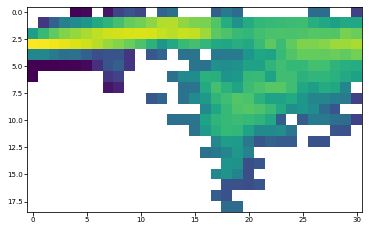

In [812]:
fig,axs=plt.subplots()
axs.imshow(np.log10(bif2_proj_hists).T)

In [ ]:
bif2_proj_hists[0]

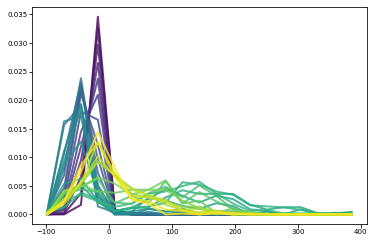

In [817]:
fig,axs=plt.subplots()
ts = np.arange(0,nt-t0,1)
cols = plt.cm.viridis(np.linspace(0,1,len(ts)))
bif2_bin_mids = 0.5*(bif2_bins[1:]+bif2_bins[:-1])
for t in np.arange(len(ts)):
    #axs.step(hbin_mids[0], bif_proj_hists[0,ts[t]], color = cols[t], linewidth=2,alpha=1)
    axs.plot(bif2_bin_mids, bif2_proj_hists[ts[t]], '-',color = cols[t], linewidth=2,alpha=0.8,markersize=8)

In [ ]:
hmax = np.amax(bif_evec_proj[:,bift]) for bift in bifts])
hmins = np.array([np.amin(gexp_pc1_proj[:,bift]) for bift in bifts])
nbins = 20
hbins = np.array([np.linspace(hmins[i], hmaxs[i]*1.001,nbins) for i in range(len(bifts))])
sgns = np.array([1,-1])
hbins = np.array([np.sort(hbins[i]*sgns[i]) for i in range(len(hbins))])
bif_proj_hists = np.array([[np.histogram(sgns[i]*gexp_pc1_proj[neut_pst_cidxs[t],bifts[i]], bins=hbins[i])[0] 
                            for t in range(npst)] 
                          for i in range(len(bifts))])
hbin_mids = 0.5*(hbins[:,1:]+hbins[:,:-1])

In [506]:
nc1 = np.array([gmm_pred_idxs[t][1].shape[0] for t in range(nt)])

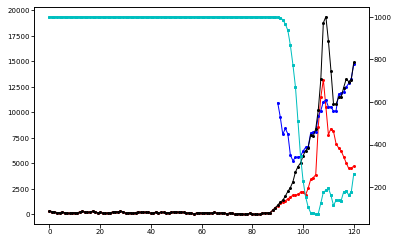

In [510]:
fig,axs=plt.subplots()
axs.plot(gmm_cov_eval_1-np.amin(gmm_cov_eval_1),'ro-')
axs.plot(gmm_cov_eval_0,'bo-')
axs.plot(pst_eig1_n,'ko-')
ax2 = axs.twinx()
ax2.plot(nc1,'cs-')


In [484]:
gmm_cov_eval

array([1063.68368925])

In [479]:
gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][0]]].toarray()

array([], shape=(0, 25289), dtype=float64)

In [480]:
t

0

In [481]:
gmm_pred_idxs[t][0]

array([], dtype=int64)

In [503]:
dat  = gexp_pc1_proj[neut_pst_cidxs[bifts[0]],bifts[0]].reshape(-1,1)
c1_idxs = np.where(mygmm.predict(dat))[0]
c0_idxs = np.where(mygmm.predict(dat)==0)[0]

In [822]:
len(c0_idxs)

815

[]

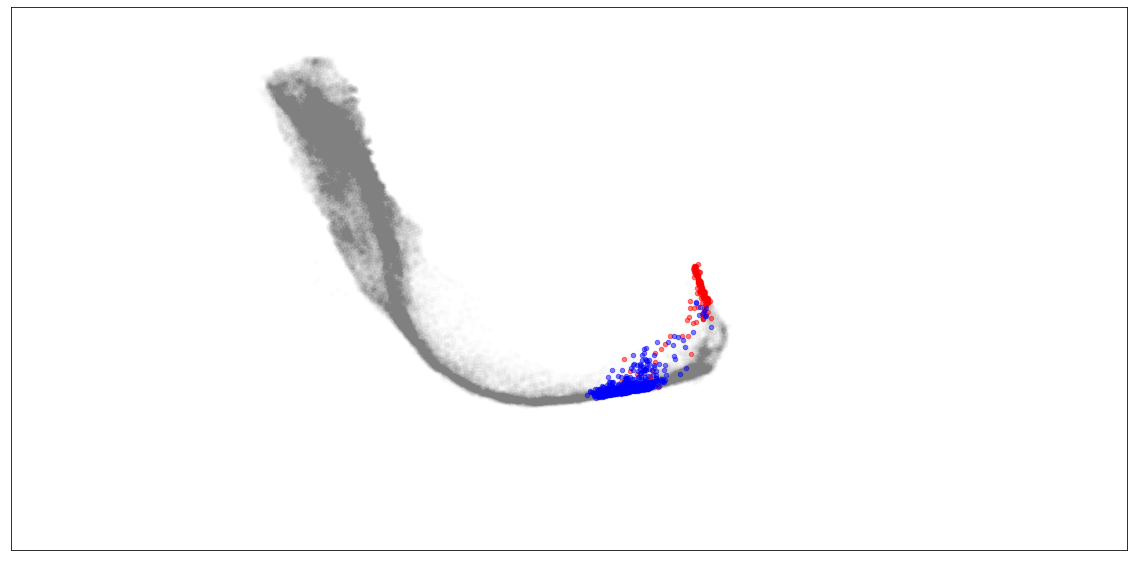

In [504]:
fig,axA=plt.subplots(figsize=(20,10))

ab_cap_fs = 7
skip=1

# plot non-neut points
traj_idxs = np.array(neut_psts[:,0],dtype='int')
idxs      = np.setdiff1d(np.arange(metadata.shape[0]), traj_idxs)
springXlims = [np.amin(metadata['SPRINGx'][idxs[::skip]]),np.amax(metadata['SPRINGx'][idxs[::skip]])]
springYlims = [np.amin(metadata['SPRINGy'][idxs[::skip]]),np.amax(metadata['SPRINGy'][idxs[::skip]])]
#axA.scatter(metadata['SPRINGx'][idxs[::skip]],metadata['SPRINGy'][idxs[::skip]], c='gray',alpha=0.5)

axA.set_xlim(springXlims[0],springXlims[1]+2500)
axA.set_ylim(springYlims[0]-1500,springYlims[1])
    
# plot points in neutrophil trajectory
skip = 1
cols = plt.cm.viridis(np.linspace(0,1,idxs.shape[0]))
# axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
#         c=cols[np.array(neut_psts[:,1],dtype='int')][::skip],alpha=0.5,s=20)

axA.scatter(metadata['SPRINGx'][traj_idxs[::skip]],metadata['SPRINGy'][traj_idxs[::skip]], 
        c='gray',alpha=0.01,s=20)




axA.scatter(metadata['SPRINGx'][neut_pst_cidxs[bifts[0]][c0_idxs]],
            metadata['SPRINGy'][neut_pst_cidxs[bifts[0]][c0_idxs]], 
        c='blue',alpha=0.5,s=20)
axA.scatter(metadata['SPRINGx'][neut_pst_cidxs[bifts[0]][c1_idxs]],
            metadata['SPRINGy'][neut_pst_cidxs[bifts[0]][c1_idxs]], 
        c='red',alpha=0.5,s=20)


axA.set_xticks([])
axA.set_yticks([])


In [ ]:
for i in range(len(grps)):
    mu_gexp = grp_mu_gexp[grps[i]]
    ggnms = grp_gnms[grps[i]]
    for g in range(mu_gexp.shape[0]):
        axC.plot(np.arange(npsts),mu_gexp[g], marker = marks[i][g],markersize=msz[i],
             color=cols[i], label=ggnms[g], fillstyle=fs[i], markeredgewidth=0.5,linestyle='none') 
    

In [412]:
grp_gexp[-1][bifts[0]][c1_idxs].shape

(185, 3)

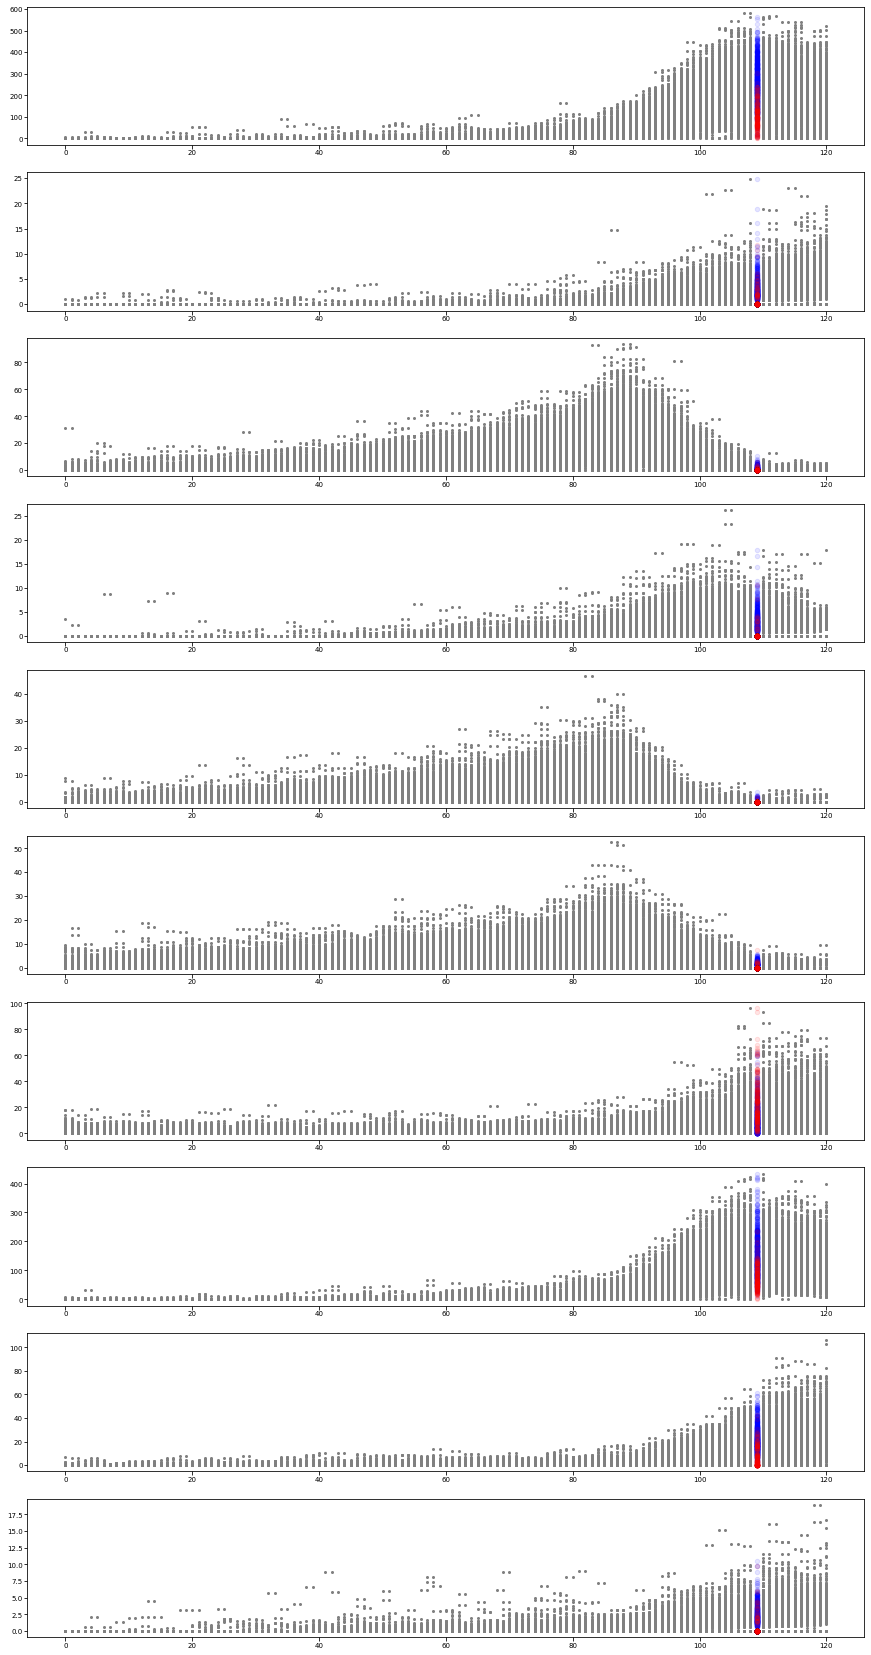

In [439]:
i = 0
ng = grp_gexp[i][0].shape[1]

fig,axs=plt.subplots(ng,1,figsize=(15,3*ng))

for j in range(ng):
    for t in range(nt):
        gexp  = grp_gexp[i][t][:,j]
        ncell = gexp.shape[0]
        
        if t==bifts[0]:
            axs[j].scatter(t*np.ones(len(c1_idxs)), gexp[c1_idxs], color='red',zorder=2,alpha=0.1,s=20)
            axs[j].scatter(t*np.ones(len(c2_idxs)), gexp[c2_idxs], color='blue',zorder=1,alpha=0.1,s=20)
        else:
            axs[j].scatter(t*np.ones(ncell), gexp, color='gray', zorder=0)



In [516]:
meanor0 = lambda x,ax: np.nanmean(x,axis=ax) if x.shape[ax]>0 else np.zeros(x.shape[:ax]+x.shape[ax+1:])

In [515]:
ax=0
gexp_lil.shape[:ax]+gexp_lil.shape[ax+1:]

(25289,)

In [517]:
nbranch = 2
mu_gexp_split = np.array([[meanor0(
    gexp_lil[neut_pst_cidxs[t][gmm_pred_idxs[t][i]]].toarray(),0) 
                          for i in range(nbranch)]
                          for t in range(nt)]) # takes like a minute

In [520]:
mu_gexp_split[:,i,grp_gidxs[0]].shape

(121, 10)

In [522]:
ngrp=len(grp_gidxs)

In [537]:
t0 = np.where(nc1<1000)[0][0]

In [535]:
bifts[1]

87

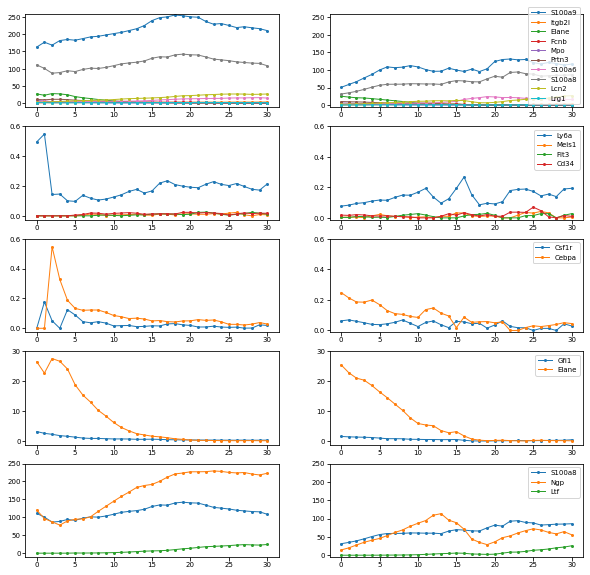

In [542]:
fig,axs=plt.subplots(ngrp,nbranch,figsize=(10,10))
cols = plt.cm.tab10.colors
ymaxs = np.array([260,0.6,0.6,30,250])
for i in range(ngrp):
    for j in range(nbranch):
        for k in range(len(grp_gidxs[i])):
            axs[i,j].plot(mu_gexp_split[t0:,j,grp_gidxs[i][k]], color=cols[k], marker='o',label=grp_gnms[i][k])
        #axs[i,j].set_yscale('symlog',linthresh=1e-1)
        axs[i,j].set_ylim(ymax=ymaxs[i])
        if j==1:
            axs[i,j].legend()

In [ ]:
grp_gidxs = [np.array([np.where(gnms==gnm)[0][0] for gnm in k]) for k in grp_gnms]

In [550]:
import csv as csv

In [563]:
mgene_fnm = '/Users/simonfreedman/data/bifurc/weinreb_2020/marker_genes.csv'
with open(mgene_fnm) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    mgene_dat = np.array([row for row in csv_reader],dtype='str')
col_names = mgene_dat[0]
mgene_dat = mgene_dat[1:]
#mgene_dat = np.genfromtxt(mgene_fnm,delimiter=',',skip_header=1)

In [613]:
mgnm_dict = {}
for ctype,_,gnm,_ in mgene_dat:
    mgnm_dict[ctype] = mgnm_dict.get(ctype,[])+[gnm]

In [614]:
list(mgnm_dict.keys()), ctypes

(['Mast cell',
  'Basophil',
  'Eosinophil',
  'Megakaryocyte',
  'Monocyte',
  'Neutrophil',
  'Lymphoid',
  'Migratory (ccr7+) DC',
  'Plasmacytoid DC',
  'Erythroid',
  'Classical DC',
  'B cell',
  'T cell',
  'NK cell'],
 array(['Baso', 'Ccr7_DC', 'Eos', 'Erythroid', 'Lymphoid', 'Mast', 'Meg',
        'Monocyte', 'Neutrophil', 'Undifferentiated', 'pDC'], dtype='<U60'))

In [579]:
mgidx_dict = {k:np.intersect1d(mgnm_dict[k],gnms,return_indices=True)[2] for k in mgnm_dict}

In [619]:
ctype_name_convert = {'Mast':'Mast cell',
  'Baso':'Basophil',
  'Eos':'Eosinophil',
  'Meg':'Megakaryocyte',
  'Monocyte':'Monocyte',
  'Neutrophil':'Neutrophil',
  'Lymphoid':'Lymphoid',
  'Ccr7_DC':'Migratory (ccr7+) DC',
  'pDC':'Plasmacytoid DC',
  'Erythroid':'Erythroid'}
ctype_name_convert.update({v:k for k,v in ctype_name_convert.items()})

In [617]:
i=0
[ctypes[i] in mgnm_dict.keys()]

[False]

In [590]:
list(mgidx_dict.keys())

['Mast cell',
 'Basophil',
 'Eosinophil',
 'Megakaryocyte',
 'Monocyte',
 'Neutrophil',
 'Lymphoid',
 'Migratory (ccr7+) DC',
 'Plasmacytoid DC',
 'Erythroid',
 'Classical DC',
 'B cell',
 'T cell',
 'NK cell']

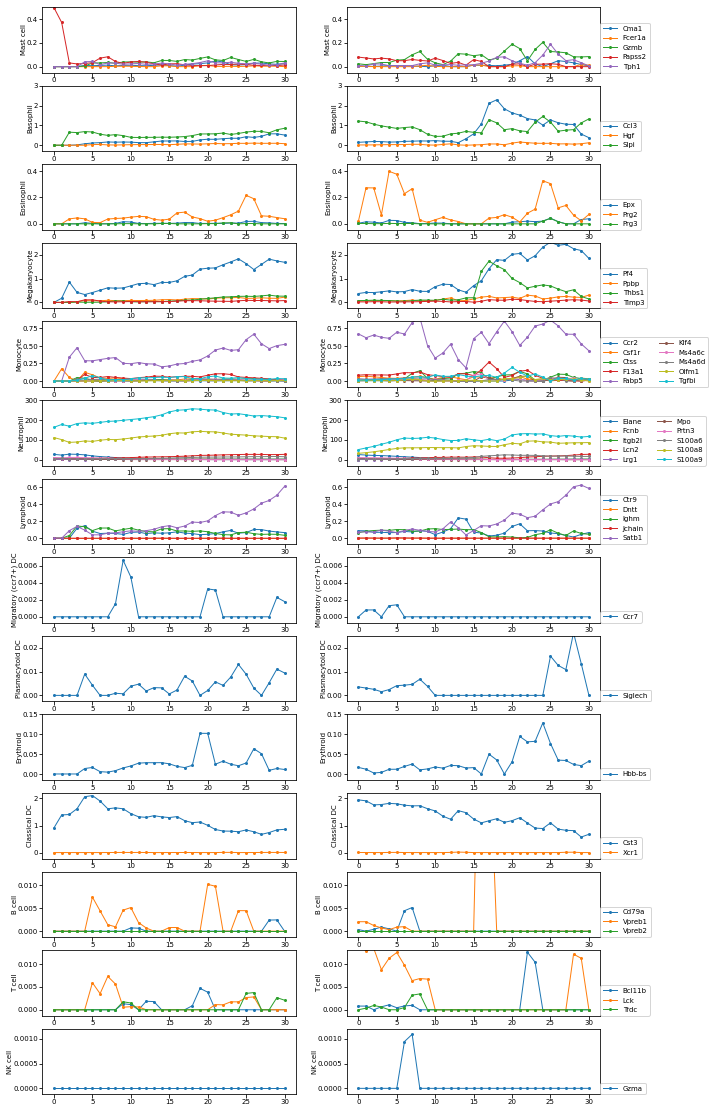

In [594]:
ntype = len(mgidx_dict)
fig,axs=plt.subplots(ntype,nbranch,figsize=(10,20))
cols = plt.cm.tab10.colors
#ymaxs = np.array([260,0.6,0.6,30,250])
ymaxs = {'Mast cell':0.5, 'Basophil':3, 'Eosinophil':0.45,'Megakaryocyte':2.5,
         'Monocyte':0.85, 'Neutrophil':300, 'Lymphoid':0.7,'Migratory (ccr7+) DC':0.007,
        'Plasmacytoid DC':0.025,'Erythroid':0.15,
 'Classical DC':2.2,
 'B cell':0.013,
 'T cell':0.013,
 'NK cell':0.0012}
for i,(ctype,gidxs) in enumerate(mgidx_dict.items()):
    for j in range(nbranch):
        for k in range(len(gidxs)):
            axs[i,j].plot(mu_gexp_split[t0:,j,gidxs[k]], color=cols[k], marker='o',label=gnms[gidxs[k]])
        axs[i,j].set_ylabel(ctype)
        #axs[i,j].set_yscale('symlog',linthresh=1e-1)
        axs[i,j].set_ylim(ymin=-0.1*ymaxs[ctype],ymax=ymaxs[ctype])
        if j==1:
            axs[i,j].legend(loc=(1,0),ncol=2 if len(gidxs)>5 else 1)

In [599]:
branch_cidxs_flat = [np.hstack([neut_pst_cidxs[t][gmm_pred_idxs[t][i]] for t in range(t0, nt)]) 
                     for i in range(nbranch)]

In [600]:
monocyte_cidxs = 

[array([  8074,  74327,   7907, ..., 125876, 126012, 130358]),
 array([ 10374,  13674,  12703, ..., 129304, 129832, 130313])]

In [623]:
mgidx_dict

{'Mast cell': array([ 5024,  7471, 11933, 17552, 23033]),
 'Basophil': array([ 4272, 12147, 21115]),
 'Eosinophil': array([ 6894, 18648, 18649]),
 'Megakaryocyte': array([17891, 18473, 22441, 22515]),
 'Monocyte': array([ 4313,  5405,  5521,  7056,  7094, 13573, 15178, 15179, 16247,
        22410]),
 'Neutrophil': array([ 6728,  7488, 13229, 13923, 14146, 15026, 18861, 20076, 20078,
        20079]),
 'Lymphoid': array([ 5496,  6290, 12695, 13282, 20147]),
 'Migratory (ccr7+) DC': array([4318]),
 'Plasmacytoid DC': array([20629]),
 'Erythroid': array([12052]),
 'Classical DC': array([ 5449, 24575]),
 'B cell': array([ 4419, 24328, 24329]),
 'T cell': array([ 3513, 13916, 23302]),
 'NK cell': array([11932])}

In [633]:
gexp_full.shape

NameError: name 'gexp_full' is not defined

array([[1.44539699],
       [3.96795176],
       [0.        ],
       ...,
       [0.        ],
       [7.39404709],
       [0.        ]])

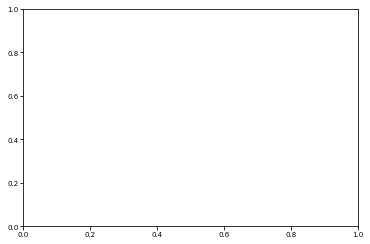

In [635]:
ctp = 'Monocyte'
fig,axs=plt.subplots()
gexp_lil[ctype_grps[ctype_idx_dict[ctp]],mgidx_dict[ctype_name_convert[ctp]][0]].toarray()

In [672]:
#d1 = gexp_lil[ctype_grps[ctype_idx_dict[ctp]],mgidx_dict[ctype_name_convert[ctp]][0]].toarray()[:,0]
#b1 = gexp_lil[branch_cidxs_flat[0],mgidx_dict[ctype_name_convert[ctp]][0]].toarray()[:,0]
#b2 = gexp_lil[branch_cidxs_flat[1],mgidx_dict[ctype_name_convert[ctp]][0]].toarray()[:,0]

nbin = 50
linbins_all = [[] for ctp in ctypes]
logbins_all = [[] for ctp in ctypes]

linhists_all = [[] for ctp in ctypes]
loghists_all = [[] for ctp in ctypes]

for c,ctp in enumerate(ctypes):
    cgrps  = [ctype_grps[ctype_idx_dict[ctp]], branch_cidxs_flat[0], branch_cidxs_flat[1]]
    mgidxs = mgidx_dict[ctype_name_convert[ctp]]
    
    for g in range(len(mgidxs)):
        cgrp_gexp = [gexp_lil[cgrp, mgidxs[g]].toarray()[:,0] for cgrp in cgrps]

        bmax = max([np.amax(gx) for gx in cgrp_gexp])
        bmin = min([np.amin(gx[gx>0]) for gx in cgrp_gexp if np.sum(gx>0)>0])

        linbins = np.hstack([[-bmin], np.linspace(bmin,bmax+bmin,nbin)])
        logbins = np.hstack([[-bmin], np.logspace(np.log10(bmin),np.log10(bmax+bmin),nbin)])

        cgrp_lin_hists = np.array([np.histogram(gx, linbins, density=True)[0] for gx in cgrp_gexp])
        cgrp_log_hists = np.array([np.histogram(gx, logbins, density=True)[0] for gx in cgrp_gexp])
        
        linbins_all[c].append(linbins)
        logbins_all[c].append(logbins)
        
        linhists_all[c].append(cgrp_lin_hists)
        loghists_all[c].append(cgrp_log_hists)

        
    #linbin_ctrs = 0.5*(linbins[1:]+linbins[:-1])
    #logbin_ctrs = 0.5*(logbins[1:]+logbins[:-1])

KeyError: 'Undifferentiated'

In [700]:
ctp = 'Monocyte'
cgrps  = [ctype_grps[ctype_idx_dict[ctp]], branch_cidxs_flat[0], branch_cidxs_flat[1]]

In [705]:
mgenes_all = np.array(np.hstack(list(mgidx_dict.values())))

In [708]:
mgexp = gexp_lil[:,mgenes_all].toarray()

In [713]:
ctype_idxs.shape,mgexp.shape,nc

((130887,), (130887, 52), 85)

In [982]:
ncell = ctype_idxs.shape[0]

non_branch_cidxs = np.setdiff1d(np.arange(ncell),np.hstack(branch_cidxs_flat))
#non_branch_cidxs = np.setdiff1d(non_branch_cidxs,ctype_grps[ctype_idx_dict['Undifferentiated']])
non_branch_gexp  = mgexp[non_branch_cidxs]
non_branch_ctp   = ctype_idxs[non_branch_cidxs]

In [983]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(non_branch_gexp, non_branch_ctp)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [755]:
branch_preds_prob = [clf.predict_proba(mgexp[cidxs]) for cidxs in branch_cidxs_flat]
branch_preds      = [clf.predict(mgexp[cidxs]) for cidxs in branch_cidxs_flat]

In [758]:
branch_preds_prob[0].shape

(20134, 10)

In [ ]:
branch_preds_probs[0]

(array([34., 52., 64., 62., 24., 44., 48., 46., 32., 76.]),
 array([0.234874 , 0.3113863, 0.3878986, 0.4644109, 0.5409232, 0.6174355,
        0.6939478, 0.7704601, 0.8469724, 0.9234847, 0.999997 ]),
 <BarContainer object of 10 artists>)

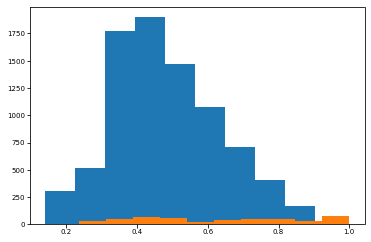

In [778]:
fig,axs=plt.subplots()
axs.hist(branch_preds_prob[0][np.where(branch_preds[0]==7)[0],7])
axs.hist(branch_preds_prob[0][np.where(branch_preds[0]==8)[0],8])


In [ ]:
pthresh = 
branch_preds_2 = np.where(branch_pr)

In [785]:
pthresh=0.5
branch_preds2 = [np.zeros_like(branch_preds[i]) for i in range(nbranch)]
for i in range(nbranch):
    maj_pred = np.where(branch_preds_prob[i]>pthresh)
    branch_preds2[i][maj_pred[0]] = maj_pred[1]

In [825]:
len(branch_preds2[1])

11176

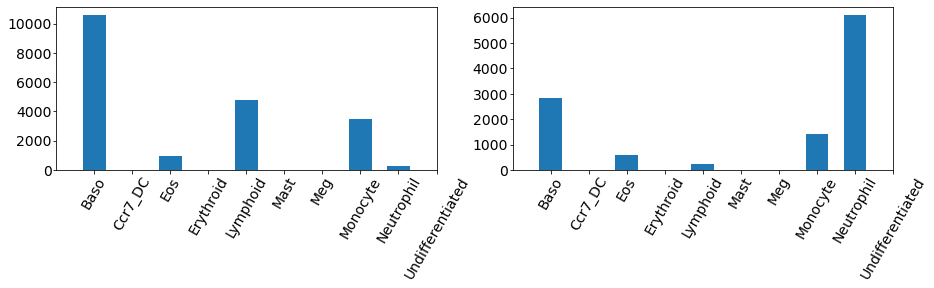

In [827]:
fig,axs=plt.subplots(1,2,figsize=(15,3))
for i in range(nbranch):
    axs[i].hist(branch_preds2[i], bins=np.arange(-0.5,10.5,1),  rwidth=0.6)

for ax in axs:
    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(ctypes, rotation=60)
    #ax.set_yscale('log')
    mf.set_axs_fontsize(ax, 14)
    ax.set_xlim(-1,9)

In [784]:
dict(zip(ctypes,list(map(len,ctype_grps))))

{'Baso': 10155,
 'Ccr7_DC': 241,
 'Eos': 555,
 'Erythroid': 686,
 'Lymphoid': 857,
 'Mast': 2584,
 'Meg': 2096,
 'Monocyte': 19182,
 'Neutrophil': 22237,
 'Undifferentiated': 72193,
 'pDC': 101}

In [753]:
clf.predict(mgexp[branch_cidxs_flat[0][0:5]])

array([7, 8, 8, 7, 8])

In [715]:
np.hstack(branch_cidxs_flat).shape

(31310,)

In [689]:
[x.shape for x in cgrps]

[(22237,), (20134,), (11176,)]

In [694]:
np.setdiff1d(cgrps[0], np.union1d(cgrps[1], cgrps[2])).shape

(6366,)

In [702]:
np.intersect1d(cgrps[0], cgrps[2]).shape

(0,)

In [674]:
ctypes

array(['Baso', 'Ccr7_DC', 'Eos', 'Erythroid', 'Lymphoid', 'Mast', 'Meg',
       'Monocyte', 'Neutrophil', 'Undifferentiated', 'pDC'], dtype='<U60')

In [668]:
bmin = min([np.amin(gx[gx>0]) for gx in cgrp_gexp if np.sum(gx>0)>0])


In [681]:
plotdir

NameError: name 'plotdir' is not defined

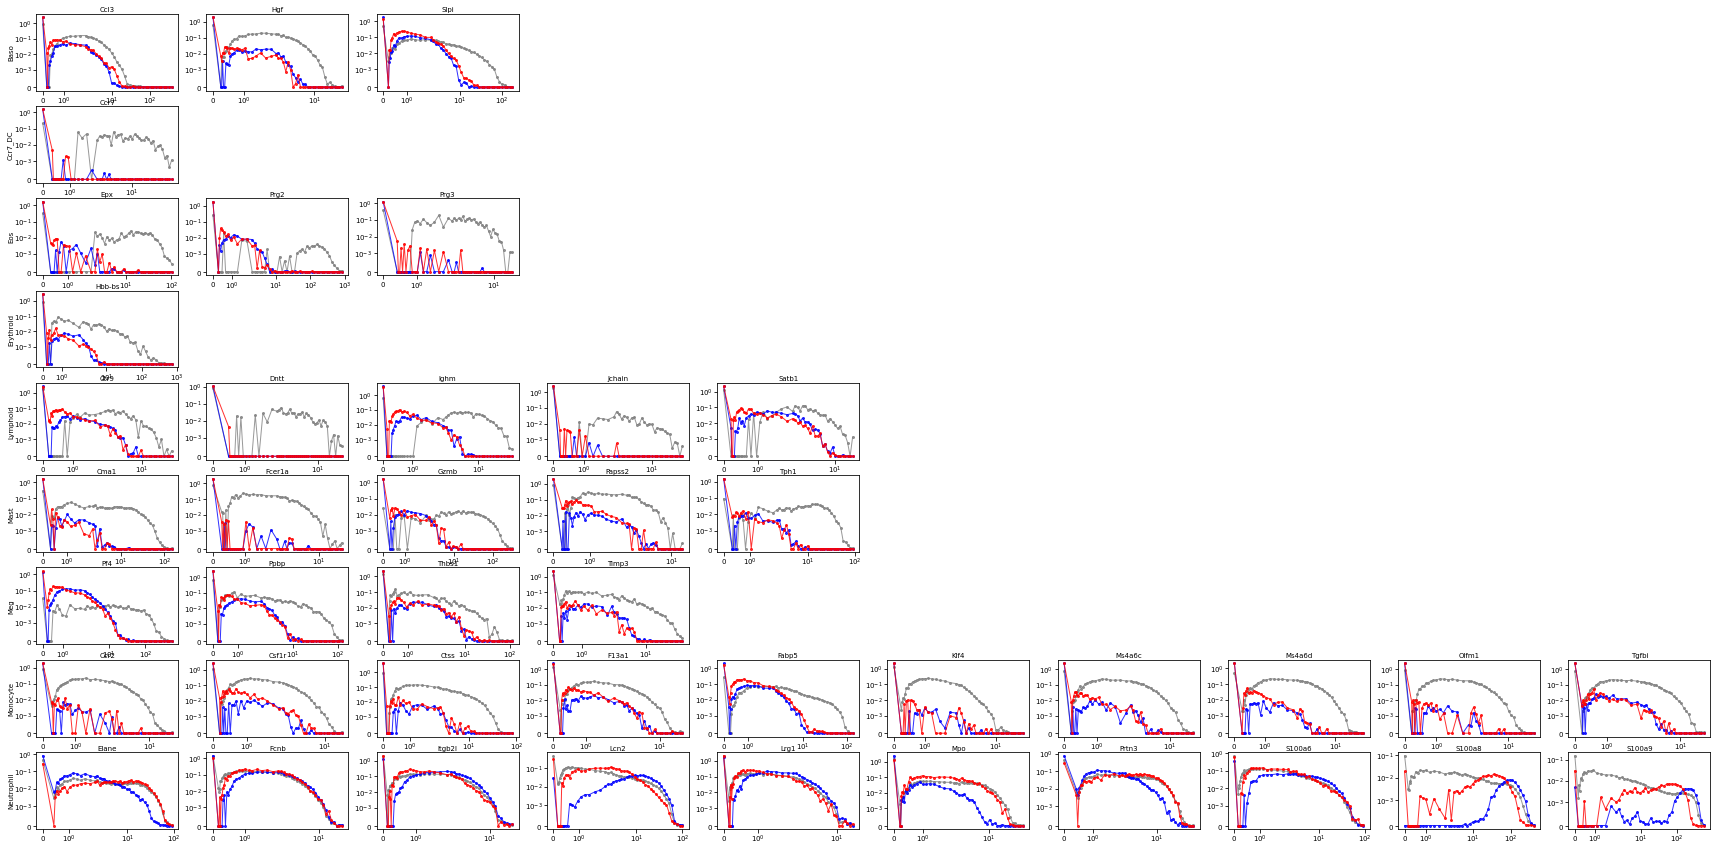

In [683]:
max_ngenes = max(list(map(len,linbins_all)))
fig,axs=plt.subplots(len(ctypes)-2, max_ngenes,figsize=(30,15))
cols = ['gray','blue','red']
for c,ctp in enumerate(ctypes[:-2]):
    mgidxs = mgidx_dict[ctype_name_convert[ctp]]
    for g in range(len(mgidxs)):
        #bedgs = linbins_all[c][g]
        bedgs = logbins_all[c][g]

        bctrs = 0.5*(bedgs[1:]+bedgs[:-1])
        for i in range(3):
            #axs[c,g].plot(bctrs,linhists_all[c][g][i], 'o-',color=cols[i],alpha=0.8)
            axs[c,g].plot(bctrs,loghists_all[c][g][i], 'o-',color=cols[i],alpha=0.8)

        if g==0:
            axs[c,g].set_ylabel(ctp)
        axs[c,g].set_title(gnms[mgidxs[g]])
        axs[c,g].set_yscale('symlog',linthresh=1e-3)
        axs[c,g].set_xscale('symlog')

    for g in range(len(mgidxs), max_ngenes):
        axs[c,g].axis('off')
        
        
plt.savefig('{0}/marker_gene_branch_pdfs_logscaled.pdf'.format(figdir), bbox_inches='tight')


In [685]:
from sklearn.svm import SVC

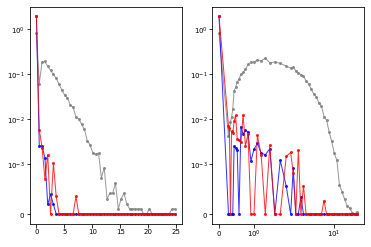

In [661]:
fig,axs=plt.subplots(1,2)
cols = ['gray','blue','red']
for i in range(3):
    axs[0].plot(linbin_ctrs,cgrp_lin_hists[i], 'o-',color=cols[i],alpha=0.8)
    axs[1].plot(logbin_ctrs,cgrp_log_hists[i], 'o-',color=cols[i],alpha=0.8)

for ax in axs:
    ax.set_yscale('symlog',linthresh=1e-3)
axs[1].set_xscale('symlog')

In [659]:
np.sum(np.diff(linbins)*cgrp_lin_hists,axis=1),np.sum(np.diff(logbins)*cgrp_log_hists,axis=1)

(array([1., 1., 1.]), array([1., 1., 1.]))

In [646]:
ctype_grps[ctype_idx_dict[ctp]]

array([     2,      8,     17, ..., 130879, 130884, 130885])

In [626]:
mgidx_dict[ctype_name_convert[ctp]]

array([ 4313,  5405,  5521,  7056,  7094, 13573, 15178, 15179, 16247,
       22410])

In [621]:
ctype_idx_dict[]

{'Baso': 0,
 'Ccr7_DC': 1,
 'Eos': 2,
 'Erythroid': 3,
 'Lymphoid': 4,
 'Mast': 5,
 'Meg': 6,
 'Monocyte': 7,
 'Neutrophil': 8,
 'Undifferentiated': 9,
 'pDC': 10}

In [602]:
ctypes,

(array(['Baso', 'Ccr7_DC', 'Eos', 'Erythroid', 'Lymphoid', 'Mast', 'Meg',
        'Monocyte', 'Neutrophil', 'Undifferentiated', 'pDC'], dtype='<U60'),
 [array([     9,     18,     27, ..., 130846, 130866, 130880]),
  array([   129,   1517,   2008,   2374,   2729,   3064,   4290,   4545,
           4727,   4876,   5036,   5069,   5307,   5607,   5668,   6188,
           6392,   6560,   6946,   7106,   7234,   7534,   7784,   8473,
           8806,  11654,  11872,  12175,  12609,  12813,  16654,  18413,
          20806,  23512,  23801,  24090,  24141,  24190,  24720,  24859,
          25934,  26991,  27295,  27502,  27871,  28008,  28306,  28417,
          28437,  29372,  29713,  30801,  30923,  31196,  31247,  31361,
          31495,  31769,  32537,  32692,  33049,  34456,  34857,  37748,
          38465,  40991,  41116,  41728,  42026,  42138,  42724,  42824,
          43841,  43850,  43995,  44499,  44773,  45135,  45172,  45533,
          45736,  46018,  46092,  46584,  46608,  46680

In [557]:
dir(csv_reader)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'dialect',
 'line_num']

In [555]:
mgene_dat[:,2]

array(['Marker gene', 'Cma1', 'Tph1', 'Papss2', 'Fcer1a', 'Gzmb', 'Hgf',
       'Ccl3', 'Slpi', 'Prg3', 'Epx', 'Prg2', 'Ppbp', 'Thbs1', 'Pf4',
       'Timp3', 'Ms4a6d', 'Fabp5', 'Ctss', 'Ms4a6c', 'Tgfbi', 'Olfm1',
       'Csf1r', 'Ccr2', 'Klf4', 'F13a1', 'S100a9', 'Itgb2l', 'Elane',
       'Fcnb', 'Mpo', 'Prtn3', 'S100a6', 'S100a8', 'Lcn2', 'Lrg1', 'Ighm',
       'Satb1', 'Dntt', 'Ctr9', 'Jchain',
       'H2-Eb1, H2-Aa, H2-Ab1, H2-DMb1', 'Ccr7', 'Siglech', 'Hbb-bs',
       'Cst3', 'Xcr1', 'Vpreb1', 'Vpreb2', 'Cd79a', 'Bcl11b', 'Trdc',
       'Lck', 'Gzma', ''], dtype='<U85')

In [ ]:
fig,axs=plt.subplots(3,1,figsize=(15,8))
for i in range(3):
    for t in range(nt):
        gexp  = grp_gexp[-1][t][:,i]
        ncell = gexp.shape[0]
        
        if t==bifts[0]:
            axs[i].scatter(t*np.ones(len(c1_idxs)), gexp[c1_idxs], color='red',zorder=1,alpha=0.1,s=20)
            axs[i].scatter(t*np.ones(len(c2_idxs)), gexp[c2_idxs], color='blue',zorder=1,alpha=0.1,s=20)
        else:
            axs[i].scatter(t*np.ones(ncell), gexp, color='gray', zorder=0)


In [3]:
pst_pc1      = np.load('{0}/dat_evec.npy'.format(eigdir))[:,0]

NameError: name 'np' is not defined